## IACD Lab Project 1 Main Notebook

## First look

The initial approach consisted of visualizing the data to understand the what information we can extract from a scan and to familiarize ourselves with the working of our auxiliary libraries

In [1]:
import pylidc as pl

pid = 'LIDC-IDRI-0001'      # Change the ID to the ID of the patient to evaluate 
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()
ann = scan.annotations
ann0 = ann[0]

### Visualization of a nodule in 3D

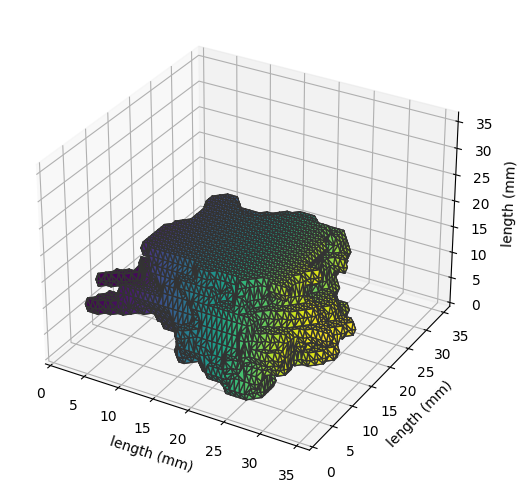

In [ ]:
ann0.visualize_in_3d()

### Scan Visualization and additional information

Loading dicom files ... This may take a moment.


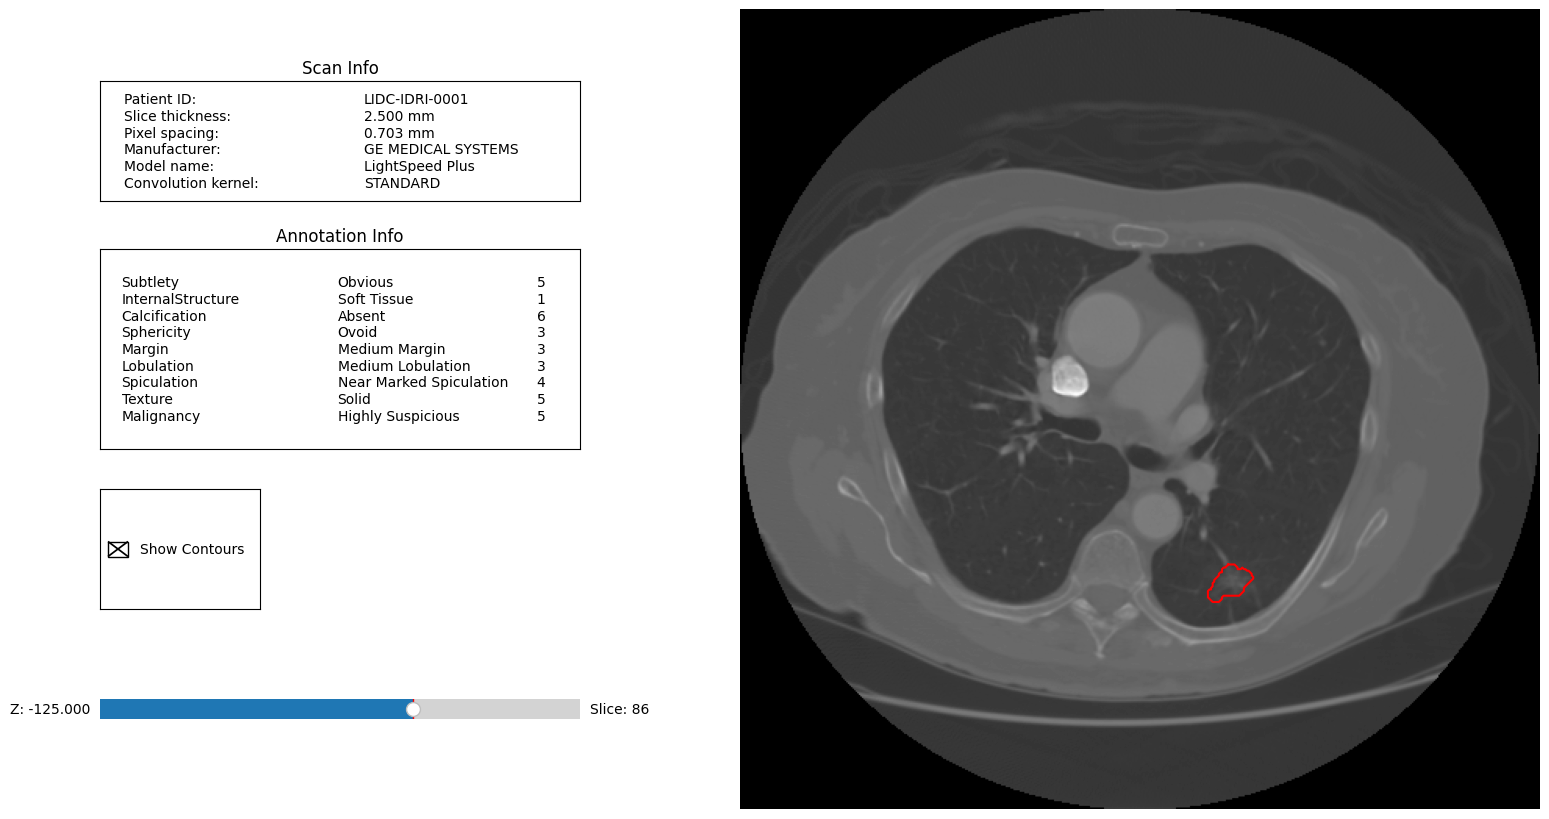

In [ ]:
ann0.visualize_in_scan()

### Finding a nodule's bounding box and mask

In [ ]:
bbox = ann0.bbox()
print("Location of the bounding box: " + str(bbox))

vol = ann0.scan.to_volume()
print("Volume of the bounding box: " + str(vol[bbox].shape))

Location of the bounding box: (slice(340, 390, None), slice(297, 338, None), slice(86, 94, None))
Loading dicom files ... This may take a moment.
Volume of the bounding box: (50, 41, 8)


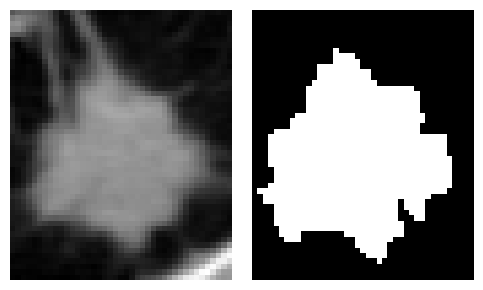

In [ ]:
import matplotlib.pyplot as plt

# Grabbing the provided mask
mask = ann0.boolean_mask()

# Use matplotlib to group both images for showing
fig,ax = plt.subplots(1,2,figsize=(5,3))

# Creating an image of the zoomed in bounding box
image1 = vol[bbox][:,:,2]
ax[0].imshow(image1, cmap=plt.cm.gray)
ax[0].axis('off')

# Creating an image of the nodule's mask
image2 = mask[:,:,2]
ax[1].imshow(image2, cmap=plt.cm.gray)
ax[1].axis('off')

# Plotting both images with matplotlib
plt.tight_layout()
plt.show()

## Data Preprocessing

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GroupShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn import svm
from sklearn.metrics import classification_report
import random
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras import metrics
from sklearn import metrics as metricssk
import math
import pickle
import os 
from sklearn.metrics import roc_auc_score  
from sklearn.metrics import roc_curve,auc 

import warnings
warnings.filterwarnings('ignore')

### Reading the data

In [2]:
# Read the csv with all the extracted data (pylidc and radiomic features combined, annotation by annotation)
df = pd.read_csv("extracted_features.csv")
testdf = df.copy(deep=True)

### Fix for a global id per nodule and a simpler patient ID

converting Patient_ID into an integer value and introducing a global "Nodule_ID" so that we can group annotations into their respective nodules

In [3]:
id = 1
node_id = []
pid_list = []

for i in range(len(df)-1):
    node_id.append(id)
    pid_list.append(int(testdf.Patient_ID[i][-4:]))
    if ((testdf.Patient_ID[i] != testdf.Patient_ID[i+1]) or (testdf.Nodule[i] != testdf.Nodule[i+1])):
        id+=1
node_id.append(id)
#pid_list.append(patientid)
pid_list.append(int(testdf.Patient_ID[i][-4:]))

testdf['Nodule_ID'] = node_id
testdf['Patient_ID_int'] = pid_list

### Separate the data into 3 dataframes

- data extracted with pylidc
- data extracted with pyradiomics
- combined data

In [4]:
# Create lists of the relevant columns for the dataframes

pylidc_columns = ['Patient_ID_int','Nodule_ID', 'Subtlety', 'InternalStructure', 'Calcification', 'Sphericity', 'Margin', 'Lobulation', 'Spiculation', 'Texture', 'Malignancy']
pylidc_columns_plus_trash = ['Patient_ID_int', 'Subtlety', 'InternalStructure', 'Calcification', 'Sphericity', 'Margin', 'Lobulation', 'Spiculation', 'Texture', 'Malignancy','Nodule',' Annotation']

In [5]:
# Grab the relevant columns from the pyradiomics extraction, discarding features which are represented by string values

pyradiomics_columns = ['Patient_ID_int']

for column, data in testdf.items():
    if (not (type(data[0]) is str)) and (column not in pylidc_columns_plus_trash):
        pyradiomics_columns.append(column)

In [6]:
# Create 2 of the main dataframes

pyradiomics_df = testdf[pyradiomics_columns]
pylidc_df = testdf[pylidc_columns]

## Treating the data before finalizing the dataframes for further use

We now group the different annotation values into nodules. We must define a metric to group the values and discard nodules which might be problematic.
- Pylidc dataframe: We use the mode for all values to account for the fact that they might not be ordinal, discarding examples where the amplitude of the values is very large
- Pyradiomics dataframe: We use the mean for all values and consider as the label "Malignancy" feature obtained from the pylidc dataframe

In [7]:
# Grouping the annotation values into nodules

pylidc_mode = pylidc_df.groupby('Nodule_ID').agg(lambda x: x.mode().values[0])
pylidc_mode = pylidc_mode[['InternalStructure', 'Calcification']]
pylidc_amp = pylidc_df.groupby('Nodule_ID').agg(lambda x: x.max()-x.min())
pylidc_mean = pylidc_df.groupby('Nodule_ID').mean()
pylidc_mean = pylidc_mean[['Patient_ID_int', 'Subtlety', 'Sphericity', 'Margin', 'Lobulation', 'Spiculation', 'Texture', 'Malignancy']]
pylidc_mean['Patient_ID_int'] = pylidc_mean['Patient_ID_int'].astype(int)

pyradiomics_mean = pyradiomics_df.groupby('Nodule_ID').mean()
pyradiomics_mean['Patient_ID_int'] = pyradiomics_mean['Patient_ID_int'].astype(int)

In [8]:
pylidc_mean.head(5)

Patient_ID_int  Subtlety  Sphericity  Margin  Lobulation  \
Nodule_ID                                                             
1                       1       5.0        3.75    3.25        3.00   
2                       2       1.5        4.00    1.50        1.00   
3                       3       1.0        5.00    2.00        1.00   
4                       3       5.0        4.00    3.25        2.00   
5                       3       3.5        3.50    4.00        1.75   

           Spiculation  Texture  Malignancy  
Nodule_ID                                    
1                 4.25     4.75        4.75  
2                 1.00     1.50        4.50  
3                 1.00     1.00        2.00  
4                 3.00     4.00        4.25  
5                 1.50     4.75        3.25

In [9]:
pyradiomics_mean.head(5)

Patient_ID_int  diagnostics_Image-original_Mean  \
Nodule_ID                                                    
1                       1                      -826.943929   
2                       2                     -1013.563545   
3                       3                      -802.641978   
4                       3                      -802.641978   
5                       3                      -802.641978   

           diagnostics_Image-original_Minimum  \
Nodule_ID                                       
1                                     -2048.0   
2                                     -3024.0   
3                                     -2048.0   
4                                     -2048.0   
5                                     -2048.0   

           diagnostics_Image-original_Maximum  \
Nodule_ID                                       
1                                      3071.0   
2                                      1752.0   
3                                      5892.0   
4                                      5892.0   
5                                      5892.0   

           diagnostics_Mask-original_VoxelNum  \
Nodule_ID                                       
1                                     5242.75   
2                                    11473.00   
3                                     2542.00   
4                                     3569.75   
5                                      231.25   

           diagnostics_Mask-original_VolumeNum  \
Nodule_ID                                        
1                                          1.0   
2                                          1.0   
3                                          1.0   
4                                          1.0   
5                                          1.0   

           diagnostics_Mask-corrected_VoxelNum  \
Nodule_ID                                        
1                                      5242.75   
2                                     11473.00   
3                                      2542.00   
4                                      3569.75   
5                                       231.25   

           diagnostics_Mask-corrected_VolumeNum  \
Nodule_ID                                         
1                                           1.0   
2                                           1.0   
3                                           1.0   
4                                           1.0   
5                                           1.0   

           diagnostics_Mask-corrected_Mean  \
Nodule_ID                                    
1                               -69.850220   
2                              -689.735875   
3                              -640.765932   
4                              -192.473453   
5                              -325.178410   

           diagnostics_Mask-corrected_Minimum  ...  \
Nodule_ID                                      ...   
1                                     -824.25  ...   
2                                     -940.00  ...   
3                                     -891.00  ...   
4                                     -719.25  ...   
5                                     -738.00  ...   

           original_glszm_SmallAreaHighGrayLevelEmphasis  \
Nodule_ID                                                  
1                                             481.671194   
2                                             163.622696   
3                                             175.560472   
4                                             261.418127   
5                                             207.224180   

           original_glszm_SmallAreaLowGrayLevelEmphasis  \
Nodule_ID                                                 
1                                              0.003443   
2                                              0.007584   
3                                              0.013967   
4                                              0.006173   
5      

In [10]:
# Eliminate the rows which have an amplitude of malignancy greater than 2 on both dataframes

count=0
rownum = 0
all_pylidc = pd.concat([pylidc_mean,pylidc_mode], axis=1)
pylidc = all_pylidc.copy(deep=True)
pyradiomics = pyradiomics_mean.copy(deep=True)
for malign in pylidc_amp['Malignancy']:
    if malign>=2:
        pylidc.drop(rownum,axis=0,inplace=True)
        pyradiomics.drop(rownum,axis=0,inplace=True)
        count+=1
    rownum+=1
print(f"Number of cases eliminated = {count}")

Number of cases eliminated = 732


In [11]:
# Turning the Malignancy feature to a binary feature

binary_malignancy = []
normalized_maligancy = []

for val in pylidc['Malignancy']:
    normalized_maligancy.append((val-1)/5)
    if val>=3:
        binary_malignancy.append(1)
    else:
        binary_malignancy.append(0)

pylidc['Binary_Malignancy'] = binary_malignancy
pylidc['Normalized_Malignancy'] = normalized_maligancy

In [12]:
# Create the final main dataframe
# (before adding labels to the radioics dataframe so that we dont have repeating columns)
pylidc['Malignancy'] = pylidc['Malignancy'].round(0).astype(int)
df_total = pd.concat([pylidc,pyradiomics], axis=1)
df_total = df_total.loc[:,~df_total.columns.duplicated()]

In [13]:
#add labels to the pyradiomics dataset
pyradiomics[['Malignancy', 'Binary_Malignancy','Normalized_Malignancy']] = pylidc[['Malignancy', 'Binary_Malignancy','Normalized_Malignancy']]

obtaining the final treated datasets:

In [14]:
pylidc.head(5)

Patient_ID_int  Subtlety  Sphericity  Margin  Lobulation  \
Nodule_ID                                                             
1                       1       5.0        3.75    3.25         3.0   
2                       2       1.5        4.00    1.50         1.0   
6                       3       4.0        4.50    5.00         1.0   
7                       4       3.0        3.50    5.00         1.0   
8                       5       2.5        4.75    4.00         1.0   

           Spiculation  Texture  Malignancy  InternalStructure  Calcification  \
Nodule_ID                                                                       
1                 4.25     4.75           5                1.0            6.0   
2                 1.00     1.50           4                1.0            6.0   
6                 1.00     5.00           4                1.0            6.0   
7                 1.00     5.00           1                1.0            3.0   
8                 1.00     4.75           3                1.0            6.0   

           Binary_Malignancy  Normalized_Malignancy  
Nodule_ID                                            
1                          1                   0.75  
2                          1                   0.70  
6                          1                   0.50  
7                          0                   0.05  
8                          0                   0.35

In [15]:
pyradiomics.head(5)

Patient_ID_int  diagnostics_Image-original_Mean  \
Nodule_ID                                                    
1                       1                      -826.943929   
2                       2                     -1013.563545   
6                       3                      -802.641978   
7                       4                     -1027.677776   
8                       5                      -795.283116   

           diagnostics_Image-original_Minimum  \
Nodule_ID                                       
1                                     -2048.0   
2                                     -3024.0   
6                                     -2048.0   
7                                     -3024.0   
8                                     -2048.0   

           diagnostics_Image-original_Maximum  \
Nodule_ID                                       
1                                      3071.0   
2                                      1752.0   
6                                      5892.0   
7                                      3071.0   
8                                      3071.0   

           diagnostics_Mask-original_VoxelNum  \
Nodule_ID                                       
1                                     5242.75   
2                                    11473.00   
6                                      680.25   
7                                       77.25   
8                                       65.75   

           diagnostics_Mask-original_VolumeNum  \
Nodule_ID                                        
1                                          1.0   
2                                          1.0   
6                                          1.0   
7                                          1.0   
8                                          1.0   

           diagnostics_Mask-corrected_VoxelNum  \
Nodule_ID                                        
1                                      5242.75   
2                                     11473.00   
6                                       680.25   
7                                        77.25   
8                                        65.75   

           diagnostics_Mask-corrected_VolumeNum  \
Nodule_ID                                         
1                                           1.0   
2                                           1.0   
6                                           1.0   
7                                           1.0   
8                                           1.0   

           diagnostics_Mask-corrected_Mean  \
Nodule_ID                                    
1                               -69.850220   
2                              -689.735875   
6                              -220.463713   
7                               -48.312863   
8                              -496.857740   

           diagnostics_Mask-corrected_Minimum  ...  \
Nodule_ID                                      ...   
1                                     -824.25  ...   
2                                     -940.00  ...   
6                                     -851.00  ...   
7                                     -572.25  ...   
8                                     -707.25  ...   

           original_glszm_ZonePercentage  original_glszm_ZoneVariance  \
Nodule_ID                                                               
1                               0.349762                   528.647056   
2                               0.145218                  1610.761075   
6                               0.473935                    79.444876   
7                               0.813145                     0.529018   
8                               0.536288                     1.341951   

           original_ngtdm_Busyness  original_ngtdm_Coarseness  \
Nodule_ID                                                       
1                         0.425589                   0.001276   
2                         1.730337                   0.001205   
6         

In [16]:
df_total.head(5)

Patient_ID_int  Subtlety  Sphericity  Margin  Lobulation  \
Nodule_ID                                                             
1                       1       5.0        3.75    3.25         3.0   
2                       2       1.5        4.00    1.50         1.0   
6                       3       4.0        4.50    5.00         1.0   
7                       4       3.0        3.50    5.00         1.0   
8                       5       2.5        4.75    4.00         1.0   

           Spiculation  Texture  Malignancy  InternalStructure  Calcification  \
Nodule_ID                                                                       
1                 4.25     4.75           5                1.0            6.0   
2                 1.00     1.50           4                1.0            6.0   
6                 1.00     5.00           4                1.0            6.0   
7                 1.00     5.00           1                1.0            3.0   
8                 1.00     4.75           3                1.0            6.0   

           ...  original_glszm_SmallAreaHighGrayLevelEmphasis  \
Nodule_ID  ...                                                  
1          ...                                     481.671194   
2          ...                                     163.622696   
6          ...                                     382.782209   
7          ...                                     645.979215   
8          ...                                      46.524926   

           original_glszm_SmallAreaLowGrayLevelEmphasis  \
Nodule_ID                                                 
1                                              0.003443   
2                                              0.007584   
6                                              0.010208   
7                                              0.048912   
8                                              0.058768   

           original_glszm_ZoneEntropy  original_glszm_ZonePercentage  \
Nodule_ID                                                              
1                            6.508549                       0.349762   
2                            6.893299                       0.145218   
6                            5.791823                       0.473935   
7                            5.259068                       0.813145   
8                            4.490178                       0.536288   

           original_glszm_ZoneVariance  original_ngtdm_Busyness  \
Nodule_ID                                                         
1                           528.647056                 0.425589   
2                          1610.761075                 1.730337   
6                            79.444876                 0.150739   
7                             0.529018                 0.040072   
8                             1.341951                 0.130958   

           original_ngtdm_Coarseness  original_ngtdm_Complexity  \
Nodule_ID                                                         
1                           0.001276                3038.782452   
2                           0.001205                 979.567361   
6                           0.005417                3097.372586   
7                           0.043983                8198.232839   
8                           0.075435                 379.275570   

           original_ngtdm_Contrast  original_ngtdm_Strength  
Nodule_ID                                                    
1                         0.310652                 1.470182  
2                         0.050911                 0.982800  
6                         0.741893                 5.336067  
7                         3.443953                55.753183  
8                         0.536612                 9.518361  

[5 rows x 129 columns]

## Analysing the resulting dataframes

Next we empirically analyse data attributes such as the label distribution to determine which learning algorithms will be appropriate for learning this dataset

In [17]:
df_total['Malignancy'].value_counts()

Malignancy
3    729
2    556
4    263
1    201
5     44
Name: count, dtype: int64

### Histogram

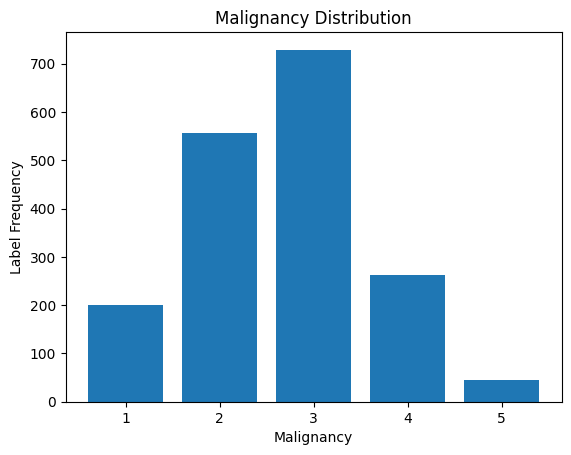

In [18]:
value_counts = df_total['Malignancy'].value_counts().sort_index()
plt.bar(value_counts.index, value_counts.values)

plt.xlabel('Malignancy')
plt.ylabel('Label Frequency')
plt.title('Malignancy Distribution')

plt.show()

### BoxPlot

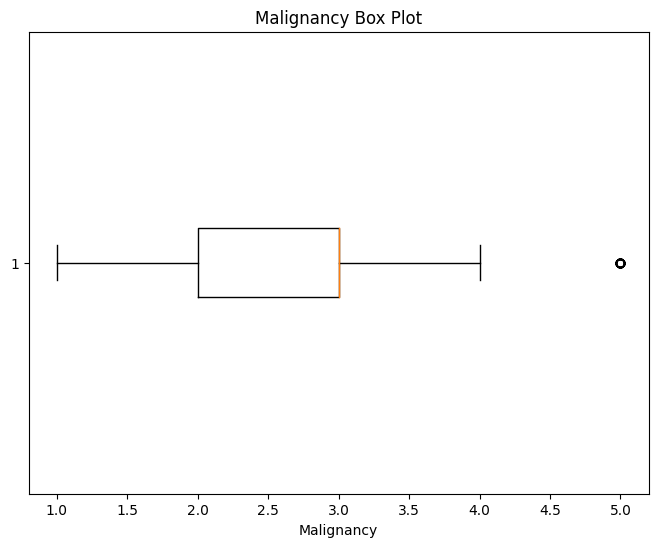

In [19]:
plt.figure(figsize=(8, 6)) 
plt.boxplot(df_total['Malignancy'], vert=False)  
plt.xlabel('Malignancy')
plt.title('Malignancy Box Plot')

plt.show()

We can see a significant difference in class frequency, particularly between 3 and 5, which might lead to bias in our model. In the context of our problem, this takes on a different significance, because it means that our model will be more likely to classify the risk of malignancy as "moderate", but will have a harder time classifying the example when the risk is very high, which is exatcly where we want it to make correct predictions.

### Heatmap

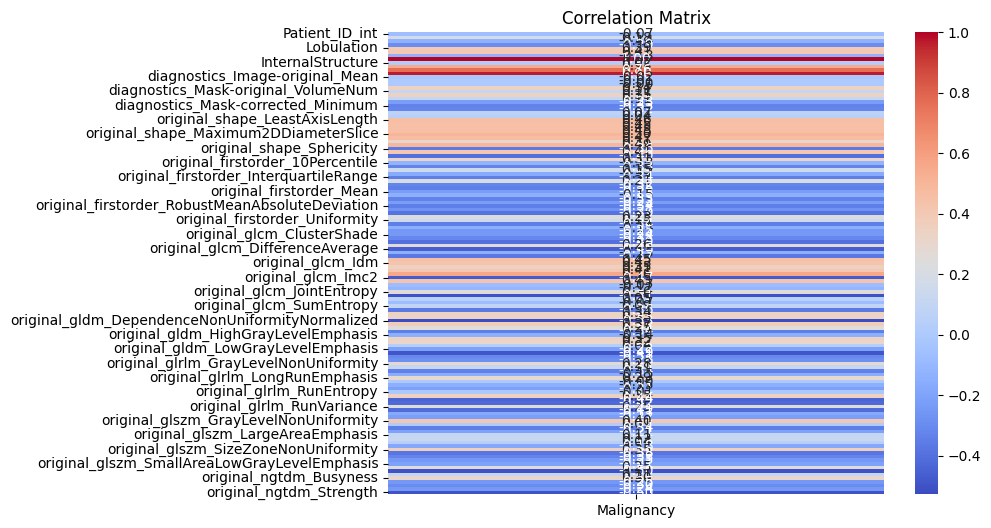

In [20]:
correlation_matrix = df_total.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix[['Malignancy']], annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')

plt.show()

In a high dimensional space, it becomes a difficult problem to correctly determine the relevance of different attributes. We will look into this question further later using a model to determine which attributes influence the prediction the most.

### Train / Test Split

we take special care when splitting the data to not split separate two nodules which belong to the same patient

In [21]:
df_total.to_csv("transition.csv")
df_total = pd.read_csv("transition.csv")
os.remove("transition.csv")
splitter = GroupShuffleSplit(test_size=.20, n_splits=5, random_state = random.randint(1,1000))
split = splitter.split(df_total, groups=df_total['Patient_ID_int'])
train_inds, test_inds = next(split)

train = df_total.iloc[train_inds]
test = df_total.iloc[test_inds]

Data Normalization

we use a variety of normalization and augmentation or reduction techniques on the data which allows us to explore how different combinations of treated data lead to different learning performance

- "to_mean": values from each attribute are represented by a factor of the standard deviation from the mean
- "normalized": values are compressed between 0 and 1
- "binary": labels are represented as {0, 1} rather than {1, 2, 3, 4, 5} (0 for any label lower than or equal to 3 and 0 otherwise)

In [22]:
X_train = train.drop(['Patient_ID_int','Nodule_ID', 'Malignancy', 'Binary_Malignancy', 'Normalized_Malignancy'],axis=1)
X_to_mean_train = (X_train-X_train.mean())/X_train.std() #subsitui o valor em cada célula pelo número de desvios padõres em relação à média
X_normalized_train = (X_train-X_train.min())/(X_train.max()-X_train.min())
Y_train = train['Malignancy']
Y_binary_train = train['Binary_Malignancy']
Y_normalized_train = train['Normalized_Malignancy']

X_test = test.drop(['Patient_ID_int','Nodule_ID', 'Malignancy', 'Binary_Malignancy', 'Normalized_Malignancy'],axis=1)
X_to_mean_test = (X_test-X_test.mean())/X_test.std() #subsitui o valor em cada célula pelo número de desvios padõres em relação à média
X_normalized_test = (X_test-X_test.min())/(X_test.max()-X_test.min())
Y_test = test['Malignancy']
Y_binary_test = test['Binary_Malignancy']
Y_normalized_test = test['Normalized_Malignancy']

X = pd.concat([X_train,X_test])
X_to_mean = pd.concat([X_to_mean_train,X_to_mean_test])
X_normalized = pd.concat([X_normalized_train,X_normalized_test])
Y = pd.concat([Y_train,Y_test])
Y_binary = pd.concat([Y_binary_train,Y_binary_test])
Y_normalized = pd.concat([Y_normalized_train,Y_normalized_test])

### Random Forest

using the random forest classifier the determine the most relevant features for classification in training a model

In [ ]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100),threshold=0.0075)
sel.fit(X_train, Y_train)


In [24]:
selected_feat= X_train.columns[(sel.get_support())]
print(f"There were selected {len(selected_feat)} features:")
for i in selected_feat:
    print(i)

There were selected 59 features:
Subtlety
Sphericity
Margin
Lobulation
Spiculation
Texture
Calcification
diagnostics_Image-original_Mean
diagnostics_Mask-original_VoxelNum
diagnostics_Mask-corrected_VoxelNum
diagnostics_Mask-corrected_Mean
diagnostics_Mask-corrected_Minimum
diagnostics_Mask-corrected_Maximum
original_shape_Elongation
original_shape_Flatness
original_shape_LeastAxisLength
original_shape_Maximum2DDiameterColumn
original_shape_Maximum2DDiameterRow
original_shape_Maximum2DDiameterSlice
original_shape_Maximum3DDiameter
original_shape_MeshVolume
original_shape_MinorAxisLength
original_shape_Sphericity
original_shape_SurfaceArea
original_shape_SurfaceVolumeRatio
original_shape_VoxelVolume
original_firstorder_90Percentile
original_firstorder_Energy
original_firstorder_Kurtosis
original_firstorder_Maximum
original_firstorder_MeanAbsoluteDeviation
original_firstorder_Minimum
original_firstorder_RobustMeanAbsoluteDeviation
original_firstorder_Skewness
original_firstorder_TotalEne

In [25]:
#saving the selected features
np.save('selected_features.npy', selected_feat)

<AxesSubplot:>

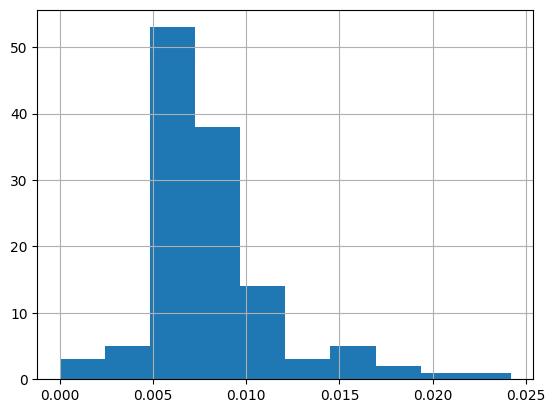

In [26]:
pd.Series(sel.estimator_.feature_importances_.ravel()).hist()

from the Random Forest results we obtain another subset of the data:
- "trimmed": remove the columns of less relevant features

In [ ]:
X_train_trimmed = X_train[selected_feat]
X_train_trimmed['InternalStructure'] = X_train['InternalStructure']
X_test_trimmed = X_test[selected_feat]
X_test_trimmed['InternalStructure'] = X_test['InternalStructure']
X_to_mean_train_trimmed = X_to_mean_train[selected_feat]
X_to_mean_train_trimmed['InternalStructure'] = X_to_mean_train['InternalStructure']
X_to_mean_test_trimmed = X_to_mean_test[selected_feat]
X_to_mean_test_trimmed['InternalStructure'] = X_to_mean_test['InternalStructure']
X_normalized_train_trimmed = X_normalized_train[selected_feat]
X_normalized_train_trimmed['InternalStructure'] = X_normalized_train['InternalStructure']
X_normalized_test_trimmed = X_normalized_test[selected_feat]
X_normalized_test_trimmed['InternalStructure'] = X_normalized_test['InternalStructure']

## Model Selection and Training

## KNN

KNN is a robust classification algorithm capable of handling bot multi and binary class classification as well as a large dimensional space that also allows for more interpretability than some other models, making it an appropriate choice for this classification class.

The model is trained over different combinations of data and labeling obtained previously in the data preprocessing section, always following the same structure.

### KNN for normal data

C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` inste

Accuracy: 0.42450142450142453


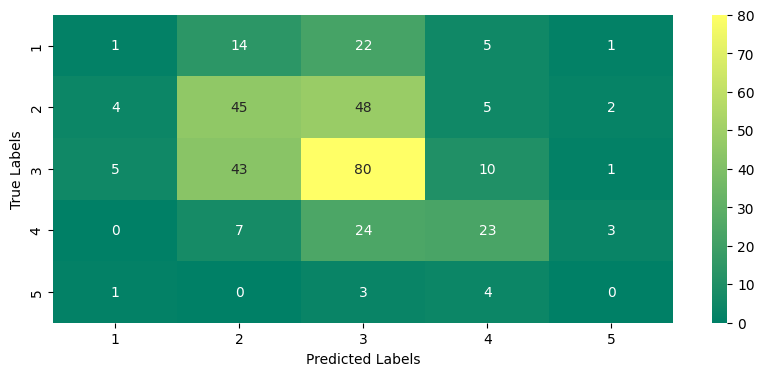

C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` inste

Binary Accuracy: 0.6467236467236467
Binary Precision: 0.6606060606060606
Binary Recall: 0.615819209039548


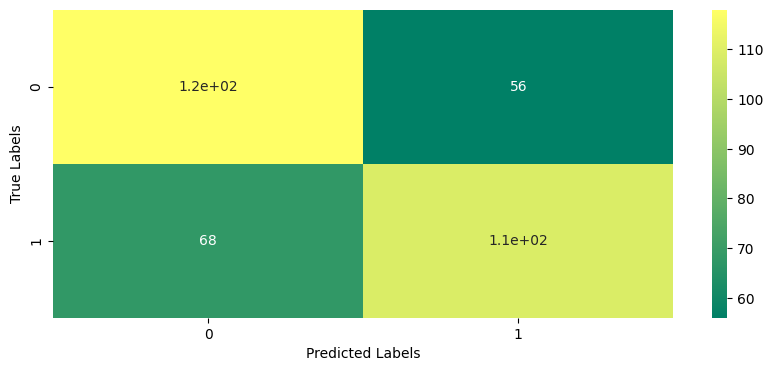

C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` inste

Trimmed Accuracy: 0.42450142450142453


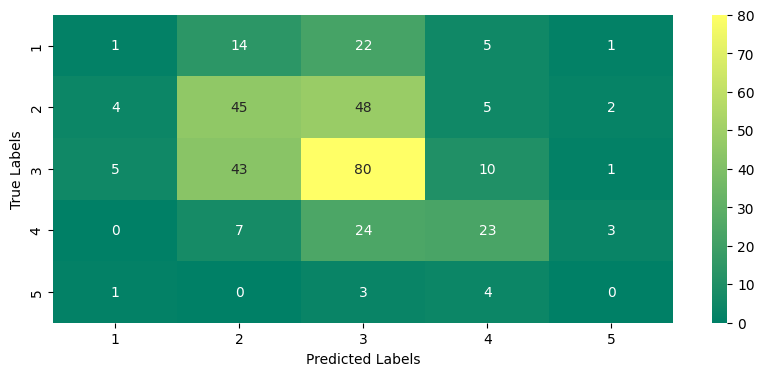

C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` inste

Trimmed Binary Accuracy: 0.6467236467236467
Trimmed Binary Precision: 0.6606060606060606
Trimmed Binary Recall: 0.615819209039548


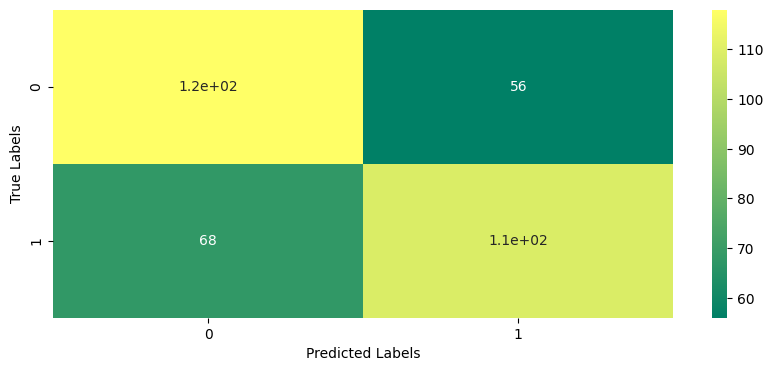

In [28]:
#full data
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_test, Y_pred), annot = True, xticklabels = [1,2,3,4,5], yticklabels = [1,2,3,4,5], cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


#data with binary label
knn_binary = KNeighborsClassifier(n_neighbors=9)
knn_binary.fit(X_train, Y_binary_train)
Y_binary_pred = knn_binary.predict(X_test)
binary_accuracy = accuracy_score(Y_binary_test, Y_binary_pred)
print("Binary Accuracy:", binary_accuracy)
binary_precision = precision_score(Y_binary_test, Y_binary_pred)
print("Binary Precision:", binary_precision)
binary_recall = recall_score(Y_binary_test, Y_binary_pred)
print("Binary Recall:", binary_recall)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_binary_test, Y_binary_pred), annot = True, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#trimmed data
knn_trimmed = KNeighborsClassifier(n_neighbors=9)
knn_trimmed.fit(X_train_trimmed, Y_train)
Y_pred_trimmed = knn_trimmed.predict(X_test_trimmed)
accuracy_trimmed = accuracy_score(Y_test, Y_pred_trimmed)
print("Trimmed Accuracy:", accuracy_trimmed)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_test, Y_pred_trimmed), annot = True, xticklabels = [1,2,3,4,5], yticklabels = [1,2,3,4,5], cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#trimmed data with binary label
knn_binary_trimmed = KNeighborsClassifier(n_neighbors=9)
knn_binary_trimmed.fit(X_train_trimmed, Y_binary_train)
Y_binary_pred_trimmed = knn_binary_trimmed.predict(X_test_trimmed)
binary_accuracy_trimmed = accuracy_score(Y_binary_test, Y_binary_pred_trimmed)
print("Trimmed Binary Accuracy:", binary_accuracy_trimmed)
binary_precision_trimmed = precision_score(Y_binary_test, Y_binary_pred_trimmed)
print("Trimmed Binary Precision:", binary_precision_trimmed)
binary_recall_trimmed = recall_score(Y_binary_test, Y_binary_pred_trimmed)
print("Trimmed Binary Recall:", binary_recall_trimmed)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_binary_test, Y_binary_pred_trimmed), annot = True, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### KNN for difference to mean data

C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` inste

Accuracy: 0.5811965811965812


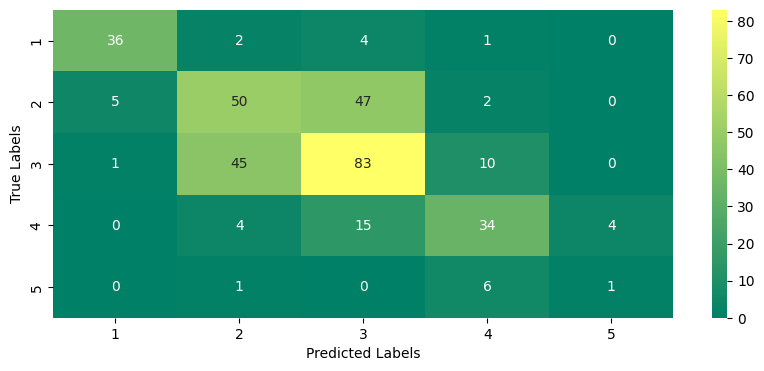

C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` inste

Binary Accuracy: 0.717948717948718
Binary Precision: 0.7671232876712328
Binary Recall: 0.632768361581921


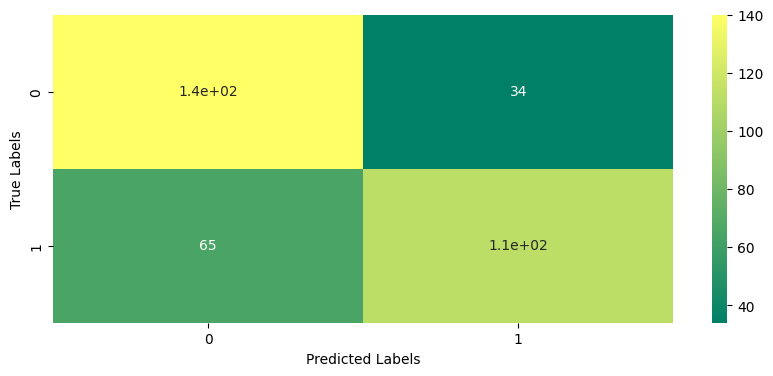

C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` inste

Trimmed Accuracy: 0.5954415954415955


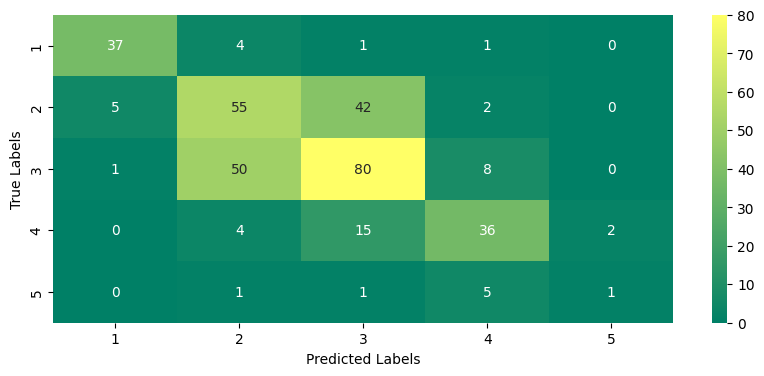

C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` inste

Trimmed Binary Accuracy: 0.7293447293447294
Trimmed Binary Precision: 0.777027027027027
Trimmed Binary Recall: 0.6497175141242938


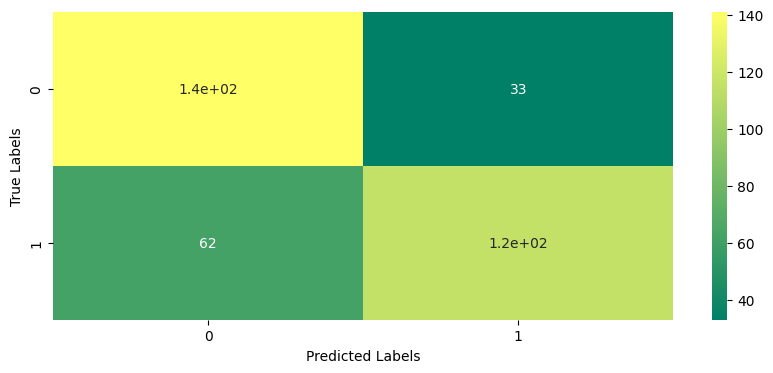

In [29]:
#same structure as previously but starting with normalized with differente to mean data
X_to_mean_test = X_to_mean_test.fillna(0)
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_to_mean_train, Y_train)
Y_pred = knn.predict(X_to_mean_test)
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_test, Y_pred), annot = True, xticklabels = [1,2,3,4,5], yticklabels = [1,2,3,4,5], cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


knn_binary = KNeighborsClassifier(n_neighbors=9)
knn_binary.fit(X_to_mean_train, Y_binary_train)
Y_binary_pred = knn_binary.predict(X_to_mean_test)
binary_accuracy = accuracy_score(Y_binary_test, Y_binary_pred)
print("Binary Accuracy:", binary_accuracy)
binary_precision = precision_score(Y_binary_test, Y_binary_pred)
print("Binary Precision:", binary_precision)
binary_recall = recall_score(Y_binary_test, Y_binary_pred)
print("Binary Recall:", binary_recall)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_binary_test, Y_binary_pred), annot = True, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



X_to_mean_test_trimmed = X_to_mean_test_trimmed.fillna(0)
knn_trimmed = KNeighborsClassifier(n_neighbors=9)
knn_trimmed.fit(X_to_mean_train_trimmed, Y_train)
Y_pred_trimmed = knn_trimmed.predict(X_to_mean_test_trimmed)
accuracy_trimmed = accuracy_score(Y_test, Y_pred_trimmed)
print("Trimmed Accuracy:", accuracy_trimmed)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_test, Y_pred_trimmed), annot = True, xticklabels = [1,2,3,4,5], yticklabels = [1,2,3,4,5], cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



knn_binary_trimmed = KNeighborsClassifier(n_neighbors=9)
knn_binary_trimmed.fit(X_to_mean_train_trimmed, Y_binary_train)
Y_binary_pred_trimmed = knn_binary_trimmed.predict(X_to_mean_test_trimmed)
binary_accuracy_trimmed = accuracy_score(Y_binary_test, Y_binary_pred_trimmed)
print("Trimmed Binary Accuracy:", binary_accuracy_trimmed)
binary_precision_trimmed = precision_score(Y_binary_test, Y_binary_pred_trimmed)
print("Trimmed Binary Precision:", binary_precision_trimmed)
binary_recall_trimmed = recall_score(Y_binary_test, Y_binary_pred_trimmed)
print("Trimmed Binary Recall:", binary_recall_trimmed)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_binary_test, Y_binary_pred_trimmed), annot = True, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### KNN for normalized data

C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` inste

Accuracy: 0.6096866096866097


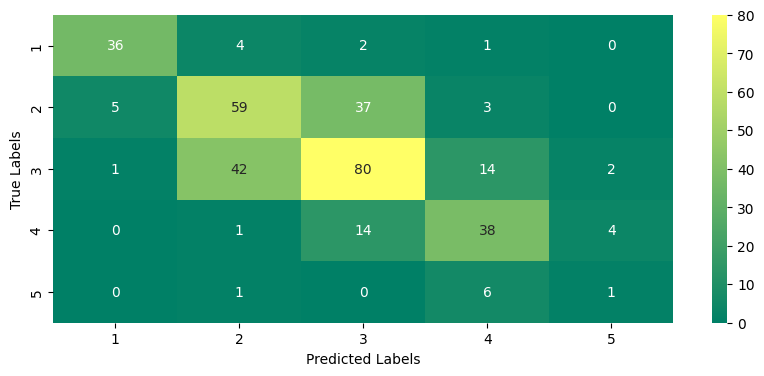

C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` inste

Binary Accuracy: 0.7264957264957265
Binary Precision: 0.7579617834394905
Binary Recall: 0.672316384180791


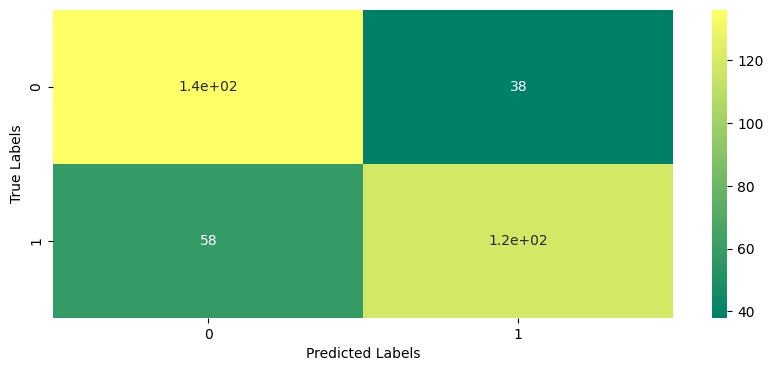

C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` inste

Trimmed Accuracy: 0.6239316239316239


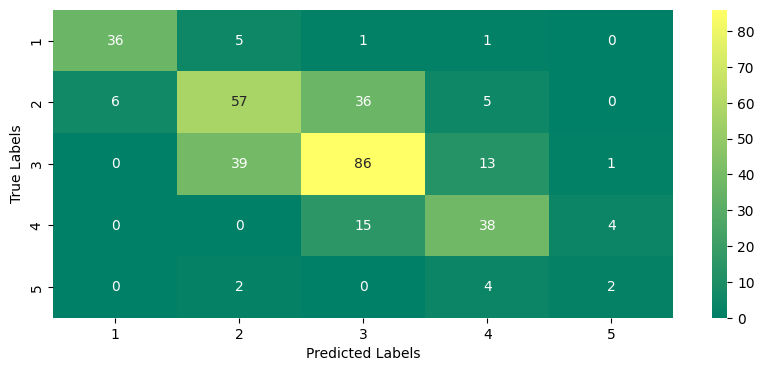

C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` inste

Trimmed Binary Accuracy: 0.7435897435897436
Trimmed Binary Precision: 0.7485714285714286
Trimmed Binary Recall: 0.7401129943502824


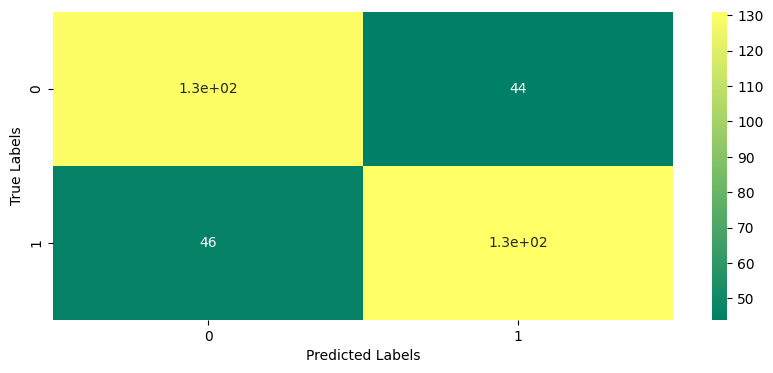

In [30]:
#same structure as previously but starting with data normalized in [0, 1]
X_normalized_test = X_normalized_test.fillna(0.5)
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_normalized_train, Y_train)
Y_pred = knn.predict(X_normalized_test)
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_test, Y_pred), annot = True, xticklabels = [1,2,3,4,5], yticklabels = [1,2,3,4,5], cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



knn_binary = KNeighborsClassifier(n_neighbors=9)
knn_binary.fit(X_normalized_train, Y_binary_train)
Y_binary_pred = knn_binary.predict(X_normalized_test)
binary_accuracy = accuracy_score(Y_binary_test, Y_binary_pred)
print("Binary Accuracy:", binary_accuracy)
binary_precision = precision_score(Y_binary_test, Y_binary_pred)
print("Binary Precision:", binary_precision)
binary_recall = recall_score(Y_binary_test, Y_binary_pred)
print("Binary Recall:", binary_recall)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_binary_test, Y_binary_pred), annot = True, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()




X_normalized_test_trimmed = X_normalized_test_trimmed.fillna(0.5)
knn_trimmed = KNeighborsClassifier(n_neighbors=9)
knn_trimmed.fit(X_normalized_train_trimmed, Y_train)
Y_pred_trimmed = knn_trimmed.predict(X_normalized_test_trimmed)
accuracy_trimmed = accuracy_score(Y_test, Y_pred_trimmed)
print("Trimmed Accuracy:", accuracy_trimmed)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_test, Y_pred_trimmed), annot = True, xticklabels = [1,2,3,4,5], yticklabels = [1,2,3,4,5], cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()




knn_binary_trimmed = KNeighborsClassifier(n_neighbors=9)
knn_binary_trimmed.fit(X_normalized_train_trimmed, Y_binary_train)
Y_binary_pred_trimmed = knn_binary_trimmed.predict(X_normalized_test_trimmed)
binary_accuracy_trimmed = accuracy_score(Y_binary_test, Y_binary_pred_trimmed)
print("Trimmed Binary Accuracy:", binary_accuracy_trimmed)
binary_precision_trimmed = precision_score(Y_binary_test, Y_binary_pred_trimmed)
print("Trimmed Binary Precision:", binary_precision_trimmed)
binary_recall_trimmed = recall_score(Y_binary_test, Y_binary_pred_trimmed)
print("Trimmed Binary Recall:", binary_recall_trimmed)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_binary_test, Y_binary_pred_trimmed), annot = True, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### KNN Training Analysis

- "Trimming" the data and utilizing only the selected features does not seem to impact the accuracy of the model significantly
- Normalizing the data with either of the proposed methods, however, does seem to have some impact on the accuracy of the model
- Accuracy when predicting with binary labels is greater in value, which is to be expected, but the difference to baseline random guessing is not as significant, which indicates that the model is not in fact generalizing better

The results obtained with KNN looked promising, especially for a "simpler" model. Given that the model has certain features, like mentioned before, that make it appropriate for the problem we are trying to tackle, we decided to select it for further analysis and tuning, which we will specify later.

## Support Vector Machine

Although SVM's are not as capable of handling a large dimensional space, they are considered one of the most interpretable learning models. Since we aim for the results of our model to be interpretable and easy to understand, testing how an SVM performs could lead to new insights.

The structure for training and analysing the different SVM models will be the same as the one followed previously with KNN

### SVM for normal data

In [31]:
# THIS WILL TAKE A REALLY LONG TIME, FOR BETTER PERFOMANCE USE DIFFERENTLY TREATED DATA

'''
Svm = svm.SVC(kernel='linear')
Svm.fit(X_train, Y_train)
Y_pred = Svm.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)
svm_binary = svm.SVC(kernel='linear')
svm_binary.fit(X_train, Y_binary_train)
Y_binary_pred = svm_binary.predict(X_test)
binary_accuracy = accuracy_score(Y_binary_test, Y_binary_pred)
print("Binary Accuracy:", binary_accuracy)
binary_precision = precision_score(Y_binary_test, Y_binary_pred)
print("Binary Precision:", binary_precision)
binary_recall = recall_score(Y_binary_test, Y_binary_pred)
print("Binary Recall:", binary_recall)
Svm_trimmed = svm.SVC(kernel='linear')
Svm_trimmed.fit(X_train_trimmed, Y_train)
Y_pred_trimmed = Svm.predict(X_test_trimmed)
accuracy_trimmed = accuracy_score(Y_test, Y_pred_trimmed)
print("Trimmed Accuracy:", accuracy_trimmed)
svm_binary_trimmed = svm.SVC(kernel='linear')
svm_binary_trimmed.fit(X_train_trimmed, Y_binary_train)
Y_binary_pred_trimmed = svm_binary_trimmed.predict(X_test_trimmed)
binary_accuracy_trimmed = accuracy_score(Y_binary_test, Y_binary_pred_trimmed)
print("Trimmed Binary Accuracy:", binary_accuracy_trimmed)
binary_precision_trimmed = precision_score(Y_binary_test, Y_binary_pred_trimmed)
print("Trimmed Binary Precision:", binary_precision_trimmed)
binary_recall_trimmed = recall_score(Y_binary_test, Y_binary_pred_trimmed)
print("Trimmed Binary Recall:", binary_recall_trimmed)
'''

'\nSvm = svm.SVC(kernel=\'linear\')\nSvm.fit(X_train, Y_train)\nY_pred = Svm.predict(X_test)\naccuracy = accuracy_score(Y_test, Y_pred)\nprint("Accuracy:", accuracy)\nsvm_binary = svm.SVC(kernel=\'linear\')\nsvm_binary.fit(X_train, Y_binary_train)\nY_binary_pred = svm_binary.predict(X_test)\nbinary_accuracy = accuracy_score(Y_binary_test, Y_binary_pred)\nprint("Binary Accuracy:", binary_accuracy)\nbinary_precision = precision_score(Y_binary_test, Y_binary_pred)\nprint("Binary Precision:", binary_precision)\nbinary_recall = recall_score(Y_binary_test, Y_binary_pred)\nprint("Binary Recall:", binary_recall)\nSvm_trimmed = svm.SVC(kernel=\'linear\')\nSvm_trimmed.fit(X_train_trimmed, Y_train)\nY_pred_trimmed = Svm.predict(X_test_trimmed)\naccuracy_trimmed = accuracy_score(Y_test, Y_pred_trimmed)\nprint("Trimmed Accuracy:", accuracy_trimmed)\nsvm_binary_trimmed = svm.SVC(kernel=\'linear\')\nsvm_binary_trimmed.fit(X_train_trimmed, Y_binary_train)\nY_binary_pred_trimmed = svm_binary_trimmed.pr

### SVM for difference to mean data

C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` inste

Accuracy: 0.5698005698005698


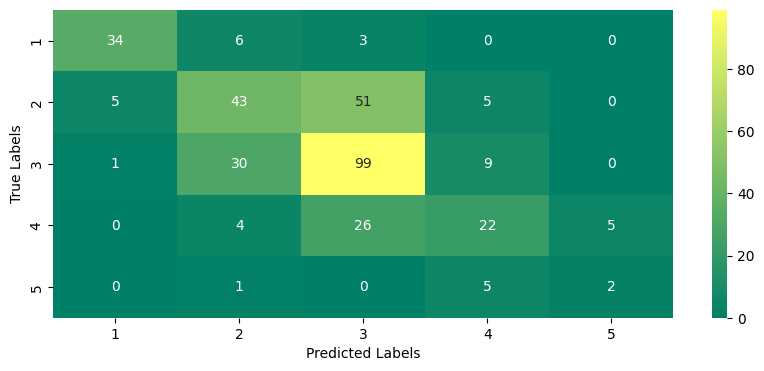

C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` inste

Binary Accuracy: 0.7407407407407407
Binary Precision: 0.7590361445783133
Binary Recall: 0.711864406779661


C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` inste

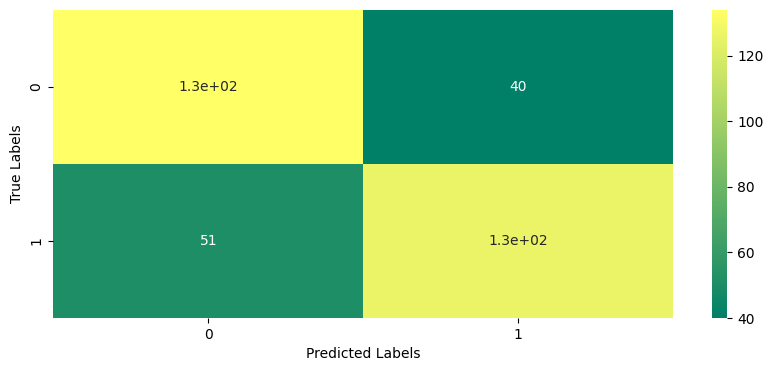

C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` inste

Trimmed Accuracy: 0.5897435897435898


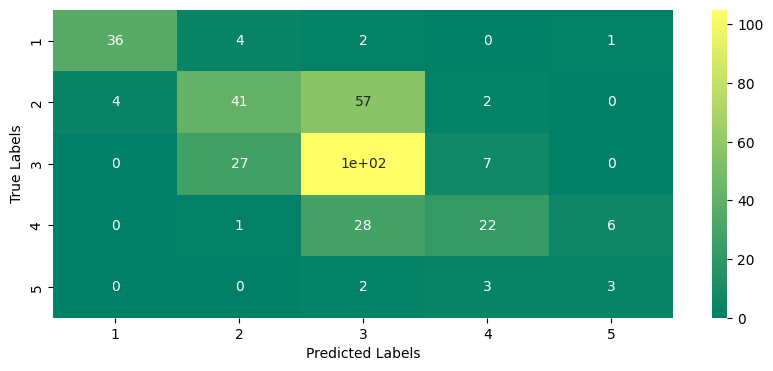

C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` inste

Trimmed Binary Accuracy: 0.7435897435897436
Trimmed Binary Precision: 0.7604790419161677
Trimmed Binary Recall: 0.7175141242937854


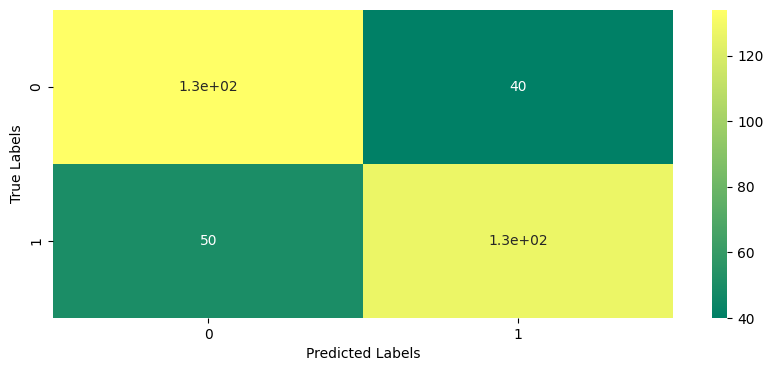

In [32]:
X_to_mean_test = X_to_mean_test.fillna(0.5)
Svm = svm.SVC(kernel='linear')
Svm.fit(X_to_mean_train, Y_train)
Y_pred = Svm.predict(X_to_mean_test)
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_test, Y_pred), annot = True, xticklabels = [1,2,3,4,5], yticklabels = [1,2,3,4,5], cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


svm_binary = svm.SVC(kernel='linear')
svm_binary.fit(X_to_mean_train, Y_binary_train)
Y_binary_pred = svm_binary.predict(X_to_mean_test)
binary_accuracy = accuracy_score(Y_binary_test, Y_binary_pred)
print("Binary Accuracy:", binary_accuracy)
binary_precision = precision_score(Y_binary_test, Y_binary_pred)
print("Binary Precision:", binary_precision)
binary_recall = recall_score(Y_binary_test, Y_binary_pred)
print("Binary Recall:", binary_recall)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_binary_test, Y_binary_pred), annot = True, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


X_to_mean_test_trimmed = X_to_mean_test_trimmed.fillna(0.5)
Svm_trimmed = svm.SVC(kernel='linear')
Svm_trimmed.fit(X_to_mean_train_trimmed, Y_train)
Y_pred_trimmed = Svm_trimmed.predict(X_to_mean_test_trimmed)
accuracy_trimmed = accuracy_score(Y_test, Y_pred_trimmed)
print("Trimmed Accuracy:", accuracy_trimmed)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_test, Y_pred_trimmed), annot = True, xticklabels = [1,2,3,4,5], yticklabels = [1,2,3,4,5], cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


svm_binary_trimmed = svm.SVC(kernel='linear')
svm_binary_trimmed.fit(X_to_mean_train_trimmed, Y_binary_train)
Y_binary_pred_trimmed = svm_binary_trimmed.predict(X_to_mean_test_trimmed)
binary_accuracy_trimmed = accuracy_score(Y_binary_test, Y_binary_pred_trimmed)
print("Trimmed Binary Accuracy:", binary_accuracy_trimmed)
binary_precision_trimmed = precision_score(Y_binary_test, Y_binary_pred_trimmed)
print("Trimmed Binary Precision:", binary_precision_trimmed)
binary_recall_trimmed = recall_score(Y_binary_test, Y_binary_pred_trimmed)
print("Trimmed Binary Recall:", binary_recall_trimmed)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_binary_test, Y_binary_pred_trimmed), annot = True, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### SVM for normalized data

C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` inste

Accuracy: 0.5982905982905983


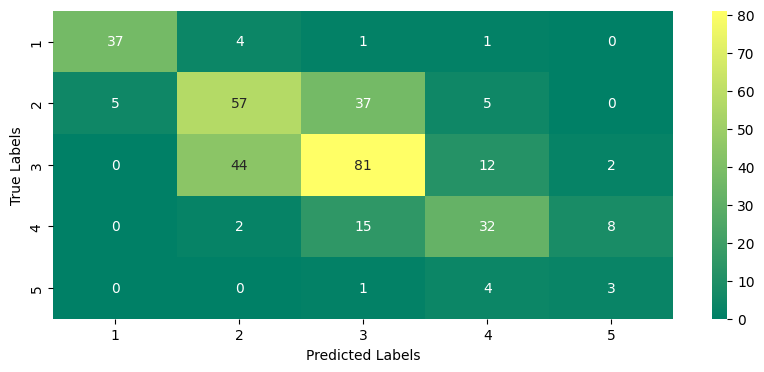

C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` inste

Binary Accuracy: 0.7464387464387464
Binary Precision: 0.7244897959183674
Binary Recall: 0.8022598870056498


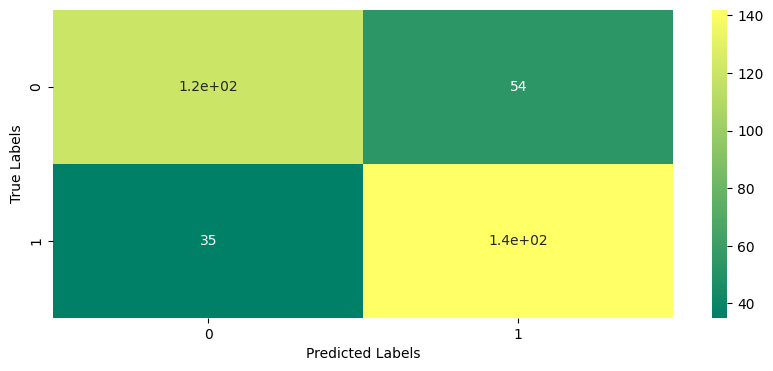

C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` inste

Trimmed Accuracy: 0.6068376068376068


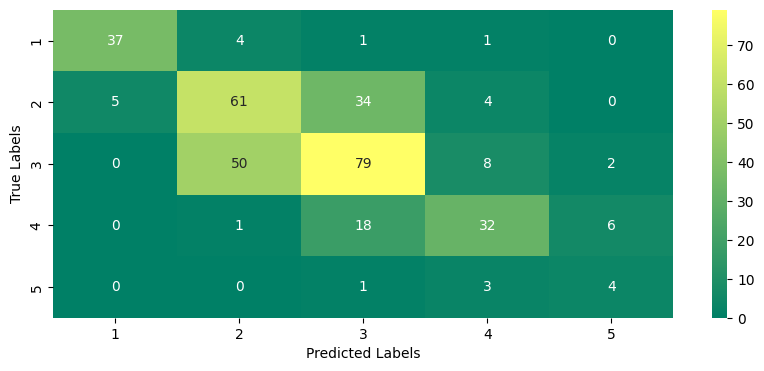

C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` inste

Trimmed Binary Accuracy: 0.7521367521367521
Trimmed Binary Precision: 0.7445652173913043
Trimmed Binary Recall: 0.7740112994350282


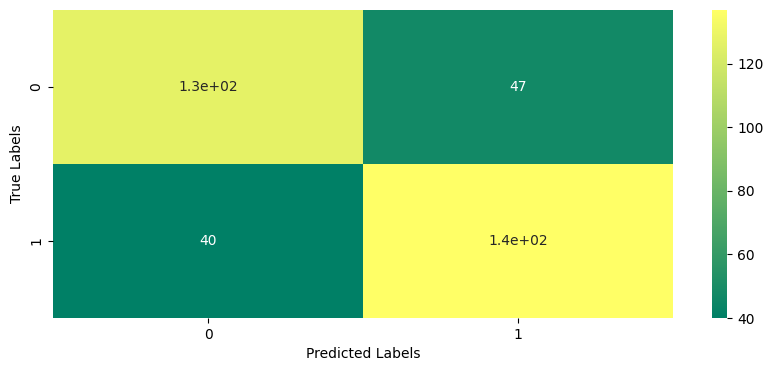

In [33]:
X_normalized_test = X_normalized_test.fillna(0.5)
Svm = svm.SVC(kernel='linear')
Svm.fit(X_normalized_train, Y_train)
Y_pred = Svm.predict(X_normalized_test)
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_test, Y_pred), annot = True, xticklabels = [1,2,3,4,5], yticklabels = [1,2,3,4,5], cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


svm_binary = svm.SVC(kernel='linear')
svm_binary.fit(X_normalized_train, Y_binary_train)
Y_binary_pred = svm_binary.predict(X_normalized_test)
binary_accuracy = accuracy_score(Y_binary_test, Y_binary_pred)
print("Binary Accuracy:", binary_accuracy)
binary_precision = precision_score(Y_binary_test, Y_binary_pred)
print("Binary Precision:", binary_precision)
binary_recall = recall_score(Y_binary_test, Y_binary_pred)
print("Binary Recall:", binary_recall)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_binary_test, Y_binary_pred), annot = True, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


X_normalized_test_trimmed = X_normalized_test_trimmed.fillna(0.5)
Svm_trimmed = svm.SVC(kernel='linear')
Svm_trimmed.fit(X_normalized_train_trimmed, Y_train)
Y_pred_trimmed = Svm_trimmed.predict(X_normalized_test_trimmed)
accuracy_trimmed = accuracy_score(Y_test, Y_pred_trimmed)
print("Trimmed Accuracy:", accuracy_trimmed)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_test, Y_pred_trimmed), annot = True, xticklabels = [1,2,3,4,5], yticklabels = [1,2,3,4,5], cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


svm_binary_trimmed = svm.SVC(kernel='linear')
svm_binary_trimmed.fit(X_normalized_train_trimmed, Y_binary_train)
Y_binary_pred_trimmed = svm_binary_trimmed.predict(X_normalized_test_trimmed)
binary_accuracy_trimmed = accuracy_score(Y_binary_test, Y_binary_pred_trimmed)
print("Trimmed Binary Accuracy:", binary_accuracy_trimmed)
binary_precision_trimmed = precision_score(Y_binary_test, Y_binary_pred_trimmed)
print("Trimmed Binary Precision:", binary_precision_trimmed)
binary_recall_trimmed = recall_score(Y_binary_test, Y_binary_pred_trimmed)
print("Trimmed Binary Recall:", binary_recall_trimmed)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_binary_test, Y_binary_pred_trimmed), annot = True, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [34]:
def majorityvote(d):
    for i in range(len(d)):
        max = 0
        maxc = -1
        for c in d.columns:
            if d.iloc[i][c]>max:
                max = d.iloc[i][c]
                maxc = c
        for c in d.columns:
            if c == maxc:
                d.iloc[i][c] = int(1)
            else:
                d.iloc[i][c] = int(0)

def turnint(d):
    for i in range(len(d)):
        for c in d.columns:
            d.iloc[i][c] = int(d.iloc[i][c]+1)

def round_binary(d):
    for i in range(len(d)):
        for c in d.columns:
            d.iloc[i][c] = round(d.iloc[i][c])

### SVM Training Analysis

The results we obtained from the training were overall similar to KNN. Since we don't see a significant improvement in performance, interpretability or any other metric that would make this model worth to develop, we decide to not select it for further development. 

## Neural Network

Neural Networks are famously hard to interpret, often being called "black boxes", meaning it is hard to understand how the model produced a certain prediction. In the context of our problem, this is an important factor to consider. However, they are also very robust and reliable models which could allow us to obtain, when properly trained and tuned, a very good performance, which is also very desirable for our problem since our model's predictions must be nearly flawless.

### NN for normal data

11/11 [==============================] - 0s 2ms/step


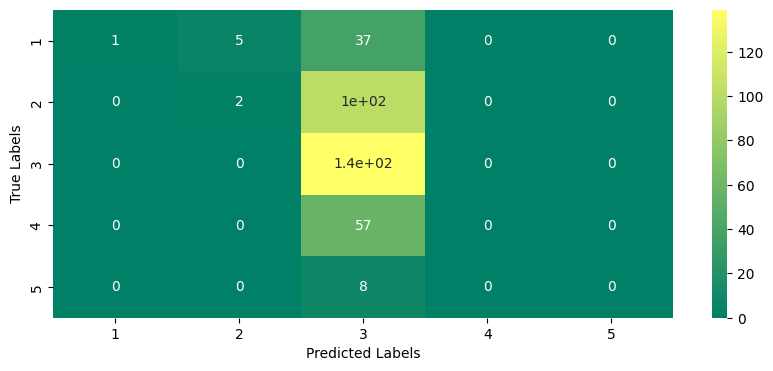

Accuracy: 0.4045584045584046
11/11 [==============================] - 0s 1ms/step


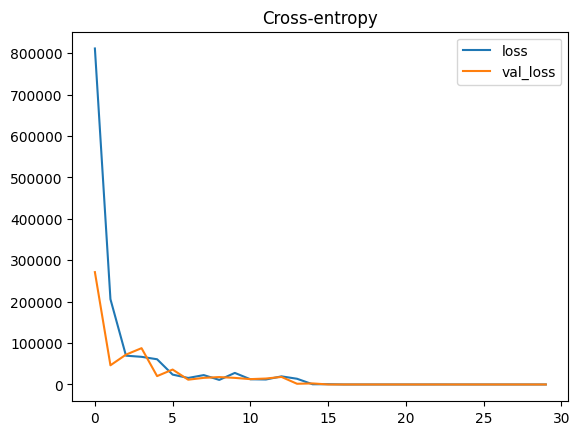

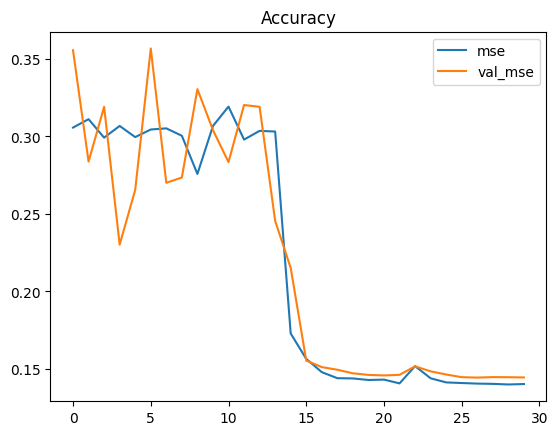

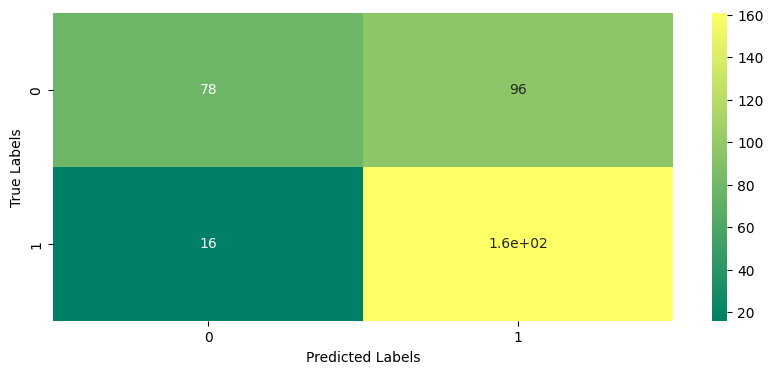

Binary Accuracy: 0.6809116809116809
11/11 [==============================] - 0s 4ms/step


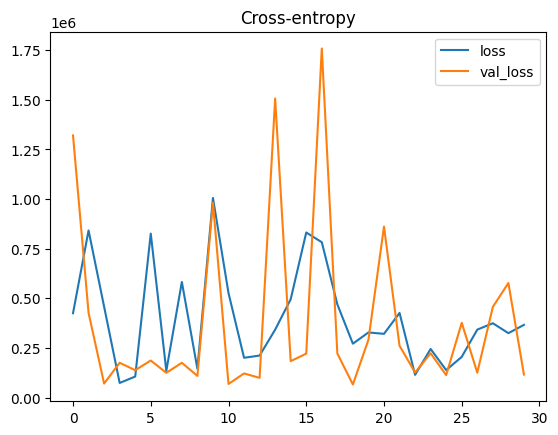

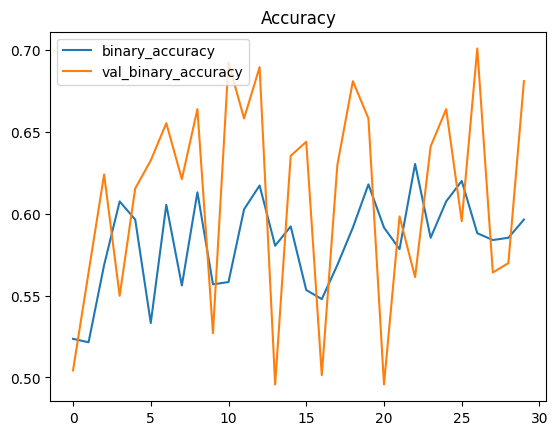

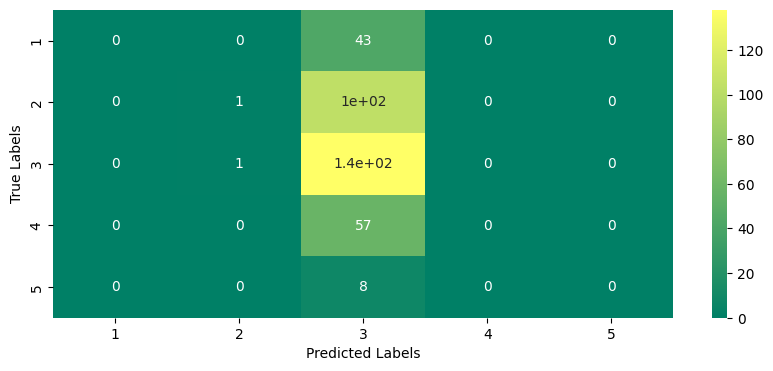

Trimmed Accuracy: 0.396011396011396
11/11 [==============================] - 0s 941us/step


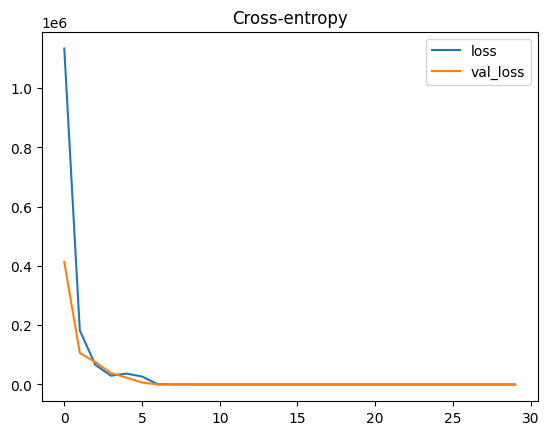

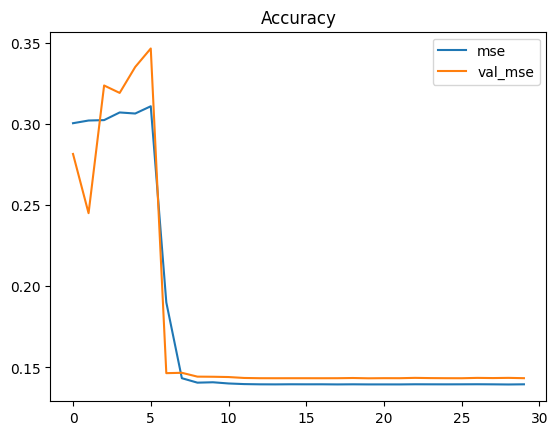

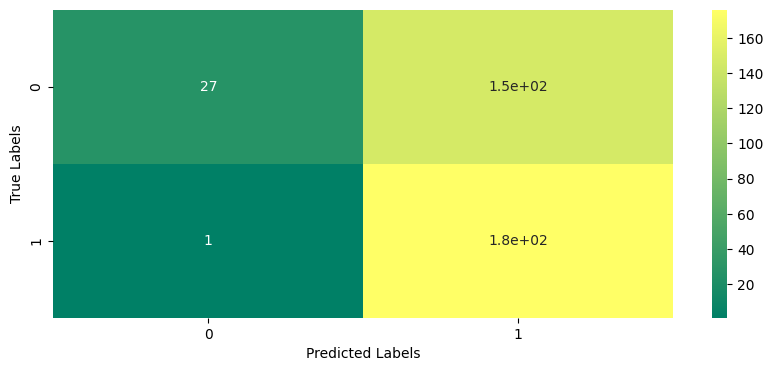

Trimmed Binary Accuracy: 0.5783475783475783


<AxesSubplot:title={'center':'Accuracy'}>

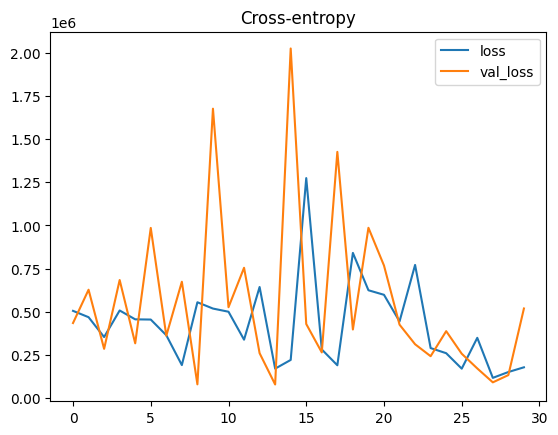

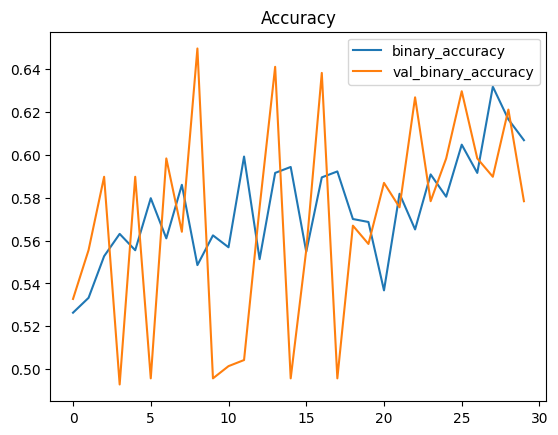

In [35]:
X_train_tf = X_train.values
X_test_tf = X_test.values
Y_train_tf = pd.get_dummies(Y_train)
Y_train_tf = Y_train_tf.values
Y_test_dummies = pd.get_dummies(Y_test)
Y_test_tf = Y_test_dummies.values
model = Sequential([Dense(100, activation='relu'),Dense(100, activation='relu'),Dense(100, activation='relu'),Dense(100, activation='relu'),Dense(500, activation='relu'),Dense(5, activation='softmax')])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['mse'])
history = model.fit(X_train_tf,Y_train_tf,validation_data = (X_test_tf,Y_test_tf), epochs=30,verbose=0)
Y_pred = model.predict(X_test_tf)
Y_pred = pd.DataFrame(Y_pred)
majorityvote(Y_pred)
Y_pred = pd.from_dummies(Y_pred)
turnint(Y_pred)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_test, Y_pred), annot = True, xticklabels = [1,2,3,4,5], yticklabels = [1,2,3,4,5], cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['mse', 'val_mse']].plot(title="Accuracy")

Y_binary_train_tf = Y_binary_train.values
Y_binary_test_tf = Y_binary_test.values
model_binary = Sequential([Dense(500, activation='relu'),Dense(1, activation='sigmoid')])
model_binary.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
history_binary = model_binary.fit(X_train_tf,Y_binary_train_tf,validation_data = (X_test_tf,Y_binary_test_tf), epochs=30,verbose=0)
Y_binary_pred = model_binary.predict(X_test_tf)
Y_binary_pred = pd.DataFrame(Y_binary_pred)
round_binary(Y_binary_pred)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_binary_test, Y_binary_pred), annot = True, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
accuracy_binary = accuracy_score(Y_binary_test, Y_binary_pred)
print("Binary Accuracy:", accuracy_binary)
history_binary_df = pd.DataFrame(history_binary.history)
history_binary_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_binary_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

X_train_trimmed_tf = X_train_trimmed.values
X_test_trimmed_tf = X_test_trimmed.values
Y_train_tf = pd.get_dummies(Y_train)
Y_train_tf = Y_train_tf.values
Y_test_dummies = pd.get_dummies(Y_test)
Y_test_tf = Y_test_dummies.values
model = Sequential([Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(5, activation='softmax')])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['mse'])
history = model.fit(X_train_trimmed_tf,Y_train_tf,validation_data = (X_test_trimmed_tf,Y_test_tf), epochs=30,verbose=0)
Y_pred = model.predict(X_test_trimmed_tf)
Y_pred = pd.DataFrame(Y_pred)
majorityvote(Y_pred)
Y_pred = pd.from_dummies(Y_pred)
turnint(Y_pred)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_test, Y_pred), annot = True, xticklabels = [1,2,3,4,5], yticklabels = [1,2,3,4,5], cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
accuracy = accuracy_score(Y_test, Y_pred)
print("Trimmed Accuracy:", accuracy)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['mse', 'val_mse']].plot(title="Accuracy")

Y_binary_train_tf = Y_binary_train.values
Y_binary_test_tf = Y_binary_test.values
model_binary = Sequential([Dense(500, activation='relu'),Dense(1, activation='sigmoid')])
model_binary.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
history_binary = model_binary.fit(X_train_trimmed_tf,Y_binary_train_tf,validation_data = (X_test_trimmed_tf,Y_binary_test_tf), epochs=30,verbose=0)
Y_binary_pred = model_binary.predict(X_test_trimmed_tf)
Y_binary_pred = pd.DataFrame(Y_binary_pred)
round_binary(Y_binary_pred)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_binary_test, Y_binary_pred), annot = True, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
accuracy_binary = accuracy_score(Y_binary_test, Y_binary_pred)
print("Trimmed Binary Accuracy:", accuracy_binary)
history_binary_df = pd.DataFrame(history_binary.history)
history_binary_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_binary_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

### NN for difference to mean data

11/11 [==============================] - 0s 3ms/step


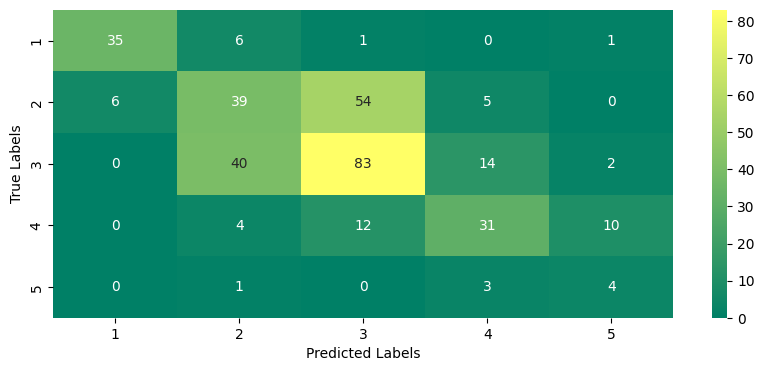

Accuracy: 0.5470085470085471
11/11 [==============================] - 0s 1000us/step


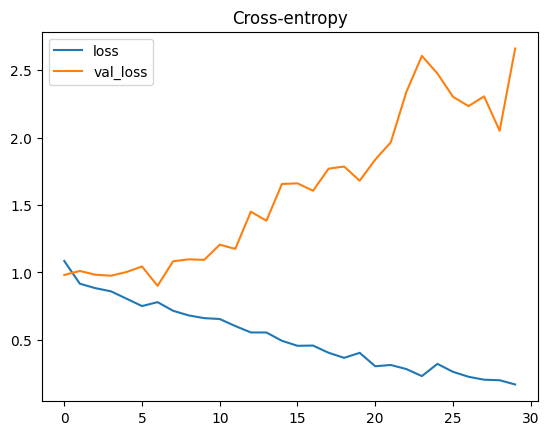

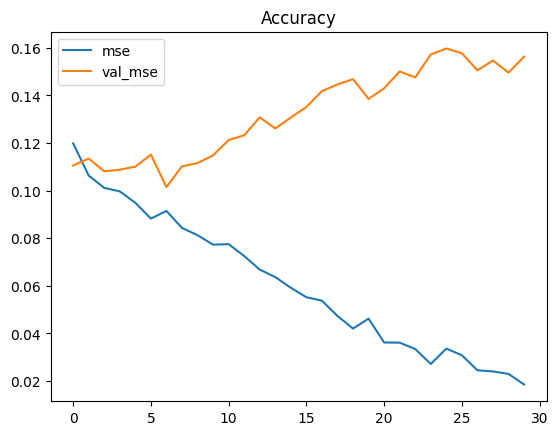

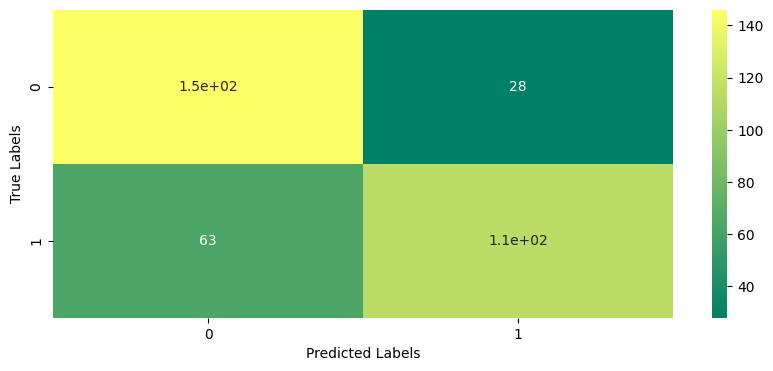

Binary Accuracy: 0.7407407407407407
11/11 [==============================] - 0s 4ms/step


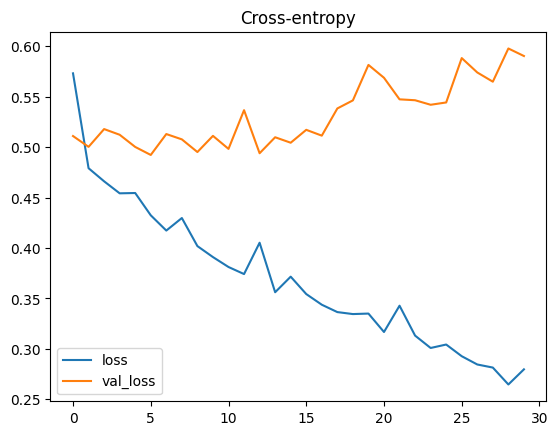

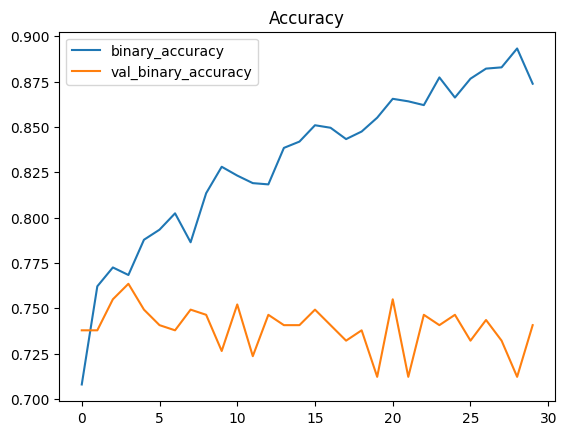

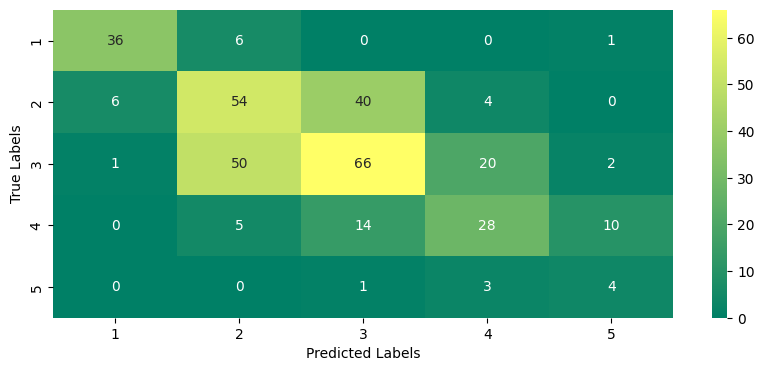

Trimmed Accuracy: 0.5356125356125356
11/11 [==============================] - 0s 1ms/step


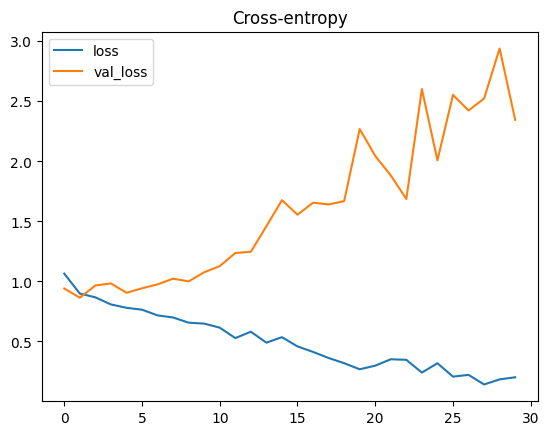

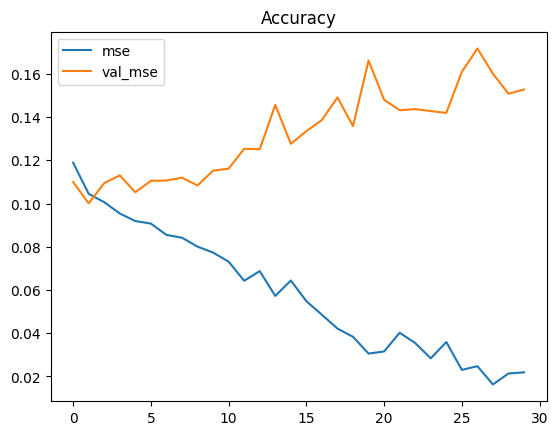

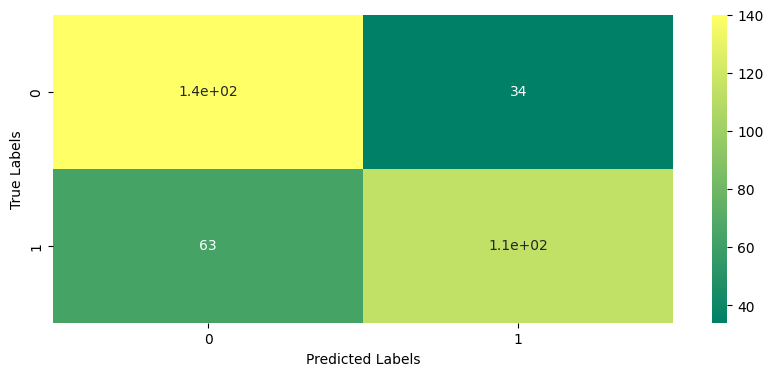

Trimmed Binary Accuracy: 0.7236467236467237


<AxesSubplot:title={'center':'Accuracy'}>

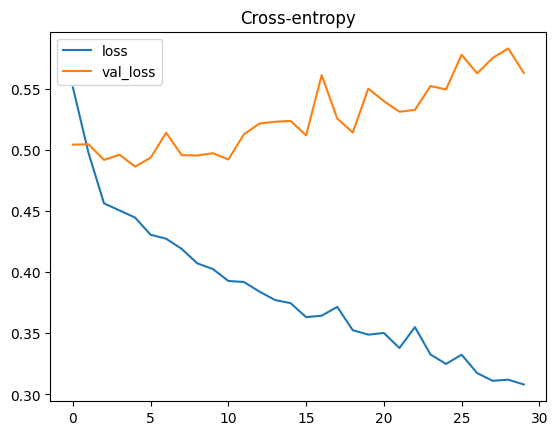

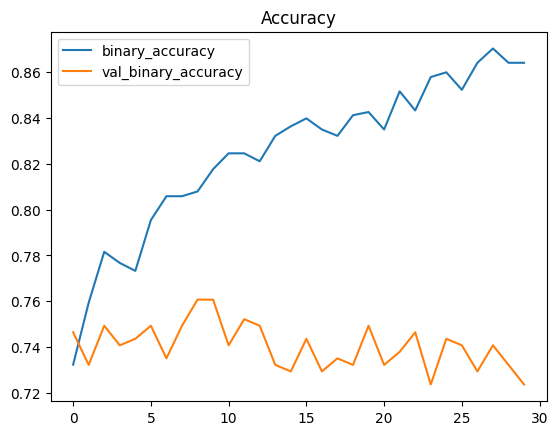

In [36]:
X_to_mean_train_tf = X_to_mean_train.values
X_to_mean_test_tf = X_to_mean_test.values
Y_train_tf = pd.get_dummies(Y_train)
Y_train_tf = Y_train_tf.values
Y_test_dummies = pd.get_dummies(Y_test)
Y_test_tf = Y_test_dummies.values
model = Sequential([Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(5, activation='softmax')])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['mse'])
history = model.fit(X_to_mean_train_tf,Y_train_tf,validation_data = (X_to_mean_test_tf,Y_test_tf), epochs=30,verbose=0)
Y_pred = model.predict(X_to_mean_test_tf)
Y_pred = pd.DataFrame(Y_pred)
majorityvote(Y_pred)
Y_pred = pd.from_dummies(Y_pred)
turnint(Y_pred)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_test, Y_pred), annot = True, xticklabels = [1,2,3,4,5], yticklabels = [1,2,3,4,5], cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['mse', 'val_mse']].plot(title="Accuracy")

Y_binary_train_tf = Y_binary_train.values
Y_binary_test_tf = Y_binary_test.values
model_binary = Sequential([Dense(500, activation='relu'),Dense(1, activation='sigmoid')])
model_binary.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
history_binary = model_binary.fit(X_to_mean_train_tf,Y_binary_train_tf,validation_data = (X_to_mean_test_tf,Y_binary_test_tf), epochs=30,verbose=0)
Y_binary_pred = model_binary.predict(X_to_mean_test_tf)
Y_binary_pred = pd.DataFrame(Y_binary_pred)
round_binary(Y_binary_pred)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_binary_test, Y_binary_pred), annot = True, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
accuracy_binary = accuracy_score(Y_binary_test, Y_binary_pred)
print("Binary Accuracy:", accuracy_binary)
history_binary_df = pd.DataFrame(history_binary.history)
history_binary_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_binary_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

X_to_mean_train_trimmed_tf = X_to_mean_train_trimmed.values
X_to_mean_test_trimmed_tf = X_to_mean_test_trimmed.values
Y_train_tf = pd.get_dummies(Y_train)
Y_train_tf = Y_train_tf.values
Y_test_dummies = pd.get_dummies(Y_test)
Y_test_tf = Y_test_dummies.values
model = Sequential([Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(5, activation='softmax')])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['mse'])
history = model.fit(X_to_mean_train_trimmed_tf,Y_train_tf,validation_data = (X_to_mean_test_trimmed_tf,Y_test_tf), epochs=30,verbose=0)
Y_pred = model.predict(X_to_mean_test_trimmed_tf)
Y_pred = pd.DataFrame(Y_pred)
majorityvote(Y_pred)
Y_pred = pd.from_dummies(Y_pred)
turnint(Y_pred)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_test, Y_pred), annot = True, xticklabels = [1,2,3,4,5], yticklabels = [1,2,3,4,5], cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
accuracy = accuracy_score(Y_test, Y_pred)
print("Trimmed Accuracy:", accuracy)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['mse', 'val_mse']].plot(title="Accuracy")

Y_binary_train_tf = Y_binary_train.values
Y_binary_test_tf = Y_binary_test.values
model_binary = Sequential([Dense(500, activation='relu'),Dense(1, activation='sigmoid')])
model_binary.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
history_binary = model_binary.fit(X_to_mean_train_trimmed_tf,Y_binary_train_tf,validation_data = (X_to_mean_test_trimmed_tf,Y_binary_test_tf), epochs=30,verbose=0)
Y_binary_pred = model_binary.predict(X_to_mean_test_trimmed_tf)
Y_binary_pred = pd.DataFrame(Y_binary_pred)
round_binary(Y_binary_pred)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_binary_test, Y_binary_pred), annot = True, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
accuracy_binary = accuracy_score(Y_binary_test, Y_binary_pred)
print("Trimmed Binary Accuracy:", accuracy_binary)
history_binary_df = pd.DataFrame(history_binary.history)
history_binary_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_binary_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

### NN for normalized data

11/11 [==============================] - 0s 4ms/step


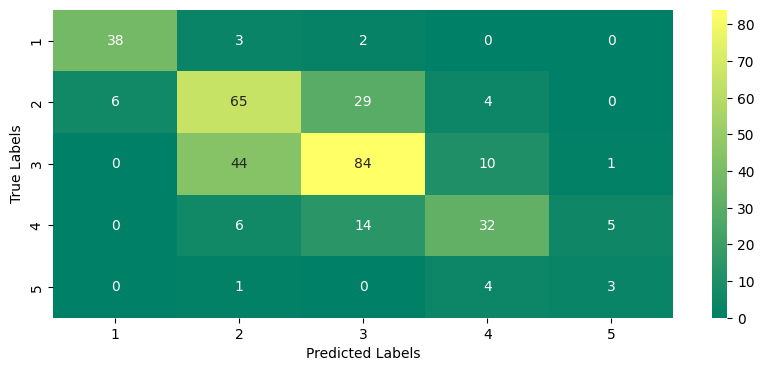

Accuracy: 0.6324786324786325
11/11 [==============================] - 0s 1ms/step


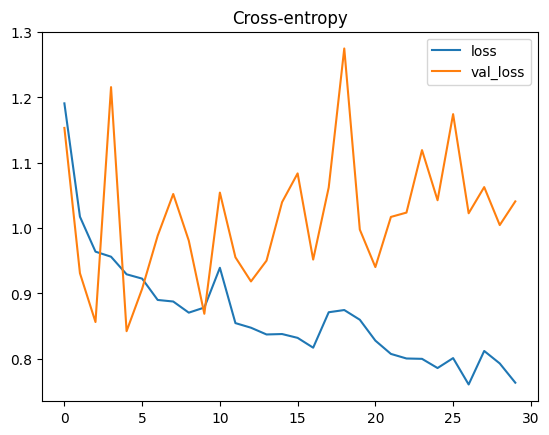

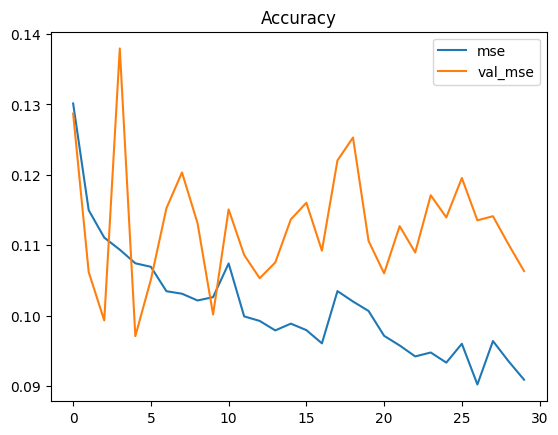

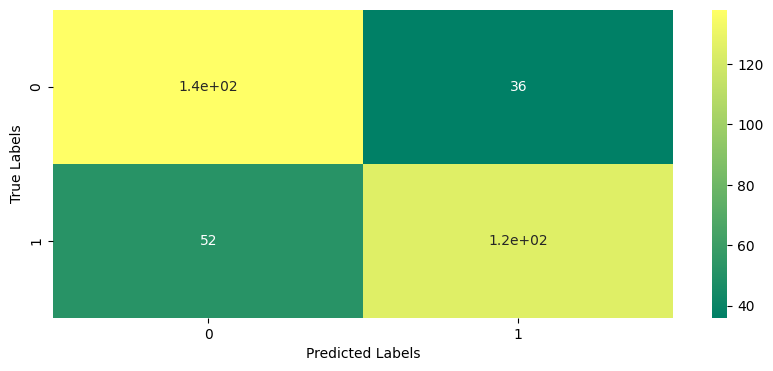

Binary Accuracy: 0.7492877492877493
11/11 [==============================] - 0s 4ms/step


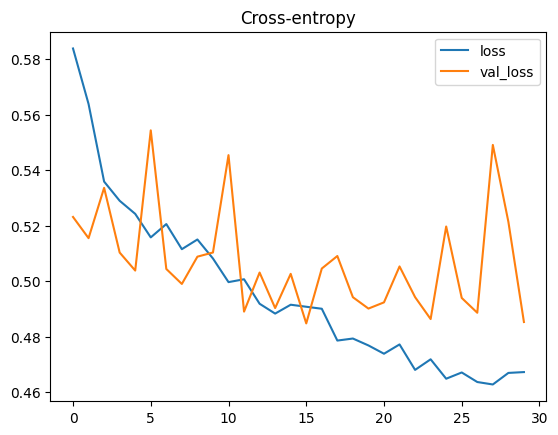

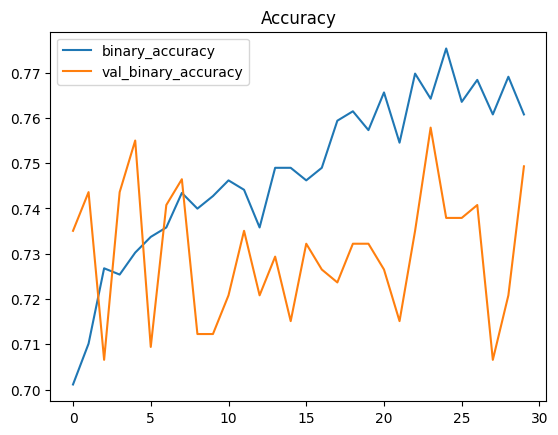

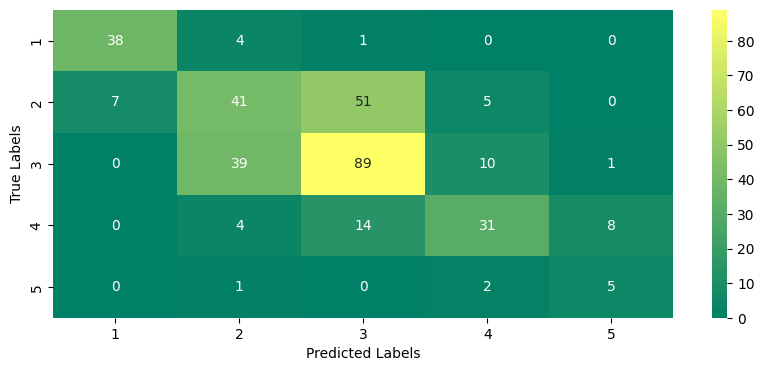

Trimmed Accuracy: 0.5811965811965812
11/11 [==============================] - 0s 1ms/step


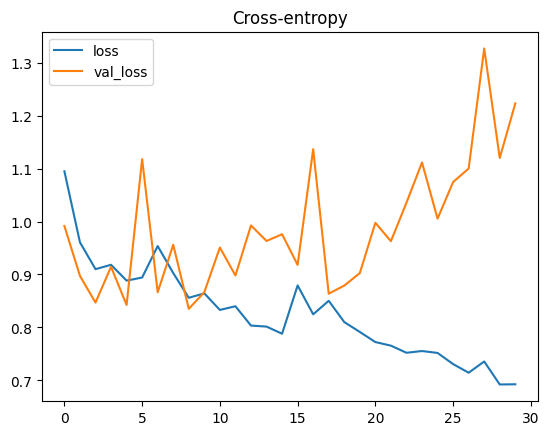

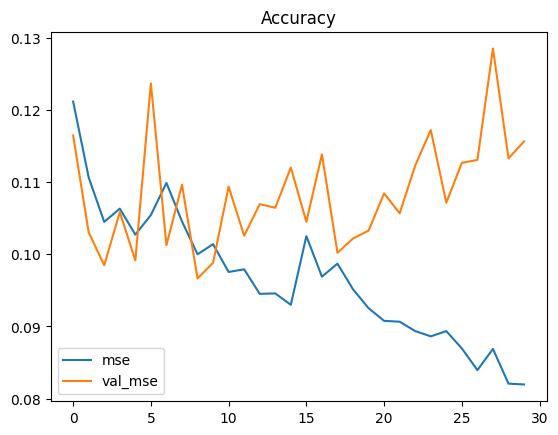

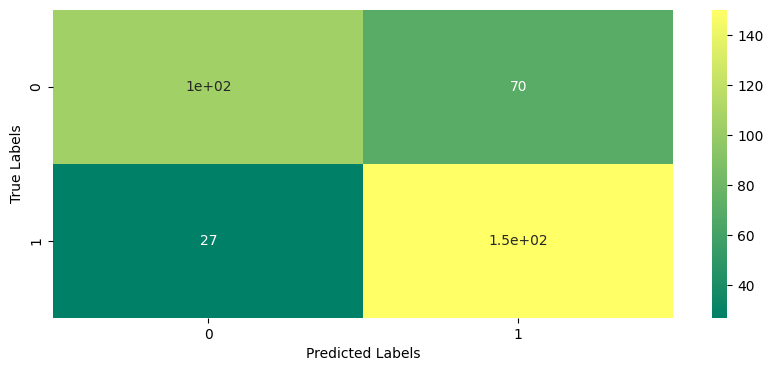

Trimmed Binary Accuracy: 0.7236467236467237


<AxesSubplot:title={'center':'Accuracy'}>

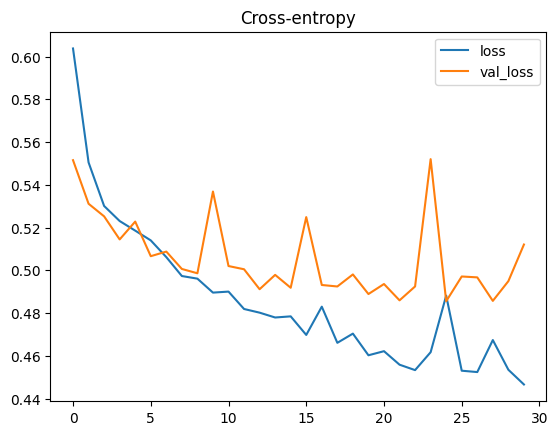

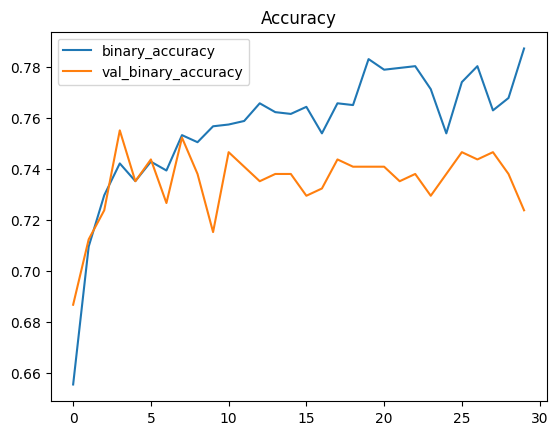

In [37]:
X_normalized_train_tf = X_normalized_train.values
X_normalized_test_tf = X_normalized_test.values
Y_train_tf = pd.get_dummies(Y_train)
Y_train_tf = Y_train_tf.values
Y_test_dummies = pd.get_dummies(Y_test)
Y_test_tf = Y_test_dummies.values
model = Sequential([Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(5, activation='softmax')])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['mse'])
history = model.fit(X_normalized_train_tf,Y_train_tf,validation_data = (X_normalized_test_tf,Y_test_tf), epochs=30,verbose=0)
Y_pred = model.predict(X_normalized_test_tf)
Y_pred = pd.DataFrame(Y_pred)
majorityvote(Y_pred)
Y_pred = pd.from_dummies(Y_pred)
turnint(Y_pred)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_test, Y_pred), annot = True, xticklabels = [1,2,3,4,5], yticklabels = [1,2,3,4,5], cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['mse', 'val_mse']].plot(title="Accuracy")

Y_binary_train_tf = Y_binary_train.values
Y_binary_test_tf = Y_binary_test.values
model_binary = Sequential([Dense(500, activation='relu'),Dense(1, activation='sigmoid')])
model_binary.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
history_binary = model_binary.fit(X_normalized_train_tf,Y_binary_train_tf,validation_data = (X_normalized_test_tf,Y_binary_test_tf), epochs=30,verbose=0)
Y_binary_pred = model_binary.predict(X_normalized_test_tf)
Y_binary_pred = pd.DataFrame(Y_binary_pred)
round_binary(Y_binary_pred)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_binary_test, Y_binary_pred), annot = True, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
accuracy_binary = accuracy_score(Y_binary_test, Y_binary_pred)
print("Binary Accuracy:", accuracy_binary)
history_binary_df = pd.DataFrame(history_binary.history)
history_binary_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_binary_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")


X_normalized_train_trimmed_tf = X_normalized_train_trimmed.values
X_normalized_test_trimmed_tf = X_normalized_test_trimmed.values
Y_train_tf = pd.get_dummies(Y_train)
Y_train_tf = Y_train_tf.values
Y_test_dummies = pd.get_dummies(Y_test)
Y_test_tf = Y_test_dummies.values
model = Sequential([Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(5, activation='softmax')])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['mse'])
history = model.fit(X_normalized_train_trimmed_tf,Y_train_tf,validation_data = (X_normalized_test_trimmed_tf,Y_test_tf), epochs=30,verbose=0)
Y_pred = model.predict(X_normalized_test_trimmed_tf)
Y_pred = pd.DataFrame(Y_pred)
majorityvote(Y_pred)
Y_pred = pd.from_dummies(Y_pred)
turnint(Y_pred)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_test, Y_pred), annot = True, xticklabels = [1,2,3,4,5], yticklabels = [1,2,3,4,5], cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
accuracy = accuracy_score(Y_test, Y_pred)
print("Trimmed Accuracy:", accuracy)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['mse', 'val_mse']].plot(title="Accuracy")

Y_binary_train_tf = Y_binary_train.values
Y_binary_test_tf = Y_binary_test.values
model_binary = Sequential([Dense(500, activation='relu'),Dense(1, activation='sigmoid')])
model_binary.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
history_binary = model_binary.fit(X_normalized_train_trimmed_tf,Y_binary_train_tf,validation_data = (X_normalized_test_trimmed_tf,Y_binary_test_tf), epochs=30,verbose=0)
Y_binary_pred = model_binary.predict(X_normalized_test_trimmed_tf)
Y_binary_pred = pd.DataFrame(Y_binary_pred)
round_binary(Y_binary_pred)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_binary_test, Y_binary_pred), annot = True, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
accuracy_binary = accuracy_score(Y_binary_test, Y_binary_pred)
print("Trimmed Binary Accuracy:", accuracy_binary)
history_binary_df = pd.DataFrame(history_binary.history)
history_binary_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_binary_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

## Linear Regression Neural Network

A possible different approach to this task would be to use a linear regression network, returning a single continous value rather than predicting a value from a set of classes. Using this network, we can transform the continous value into a probability value between 0 and 1, which, in the context of our healthcare problem, constitutes a more expressive result where there is less ambiguity.

### Linear Regression Neural Network for normal data

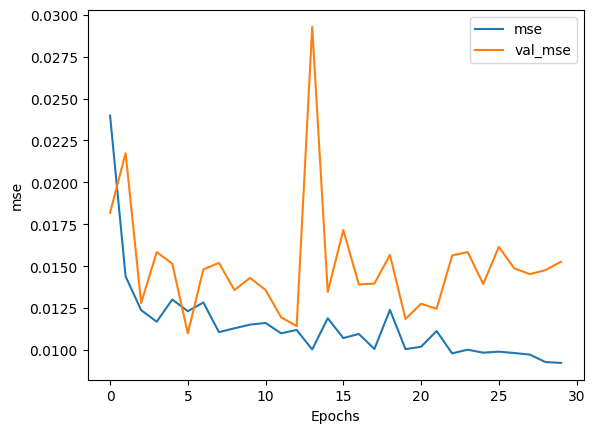

In [38]:
X_train_tf = X_train.values
X_test_tf = X_test.values
Y_normalized_train_tf = Y_normalized_train.values
Y_normalized_test_tf = Y_normalized_test.values
model_normalized = Sequential([Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(1, activation='linear')])
model_normalized.compile(loss=tf.keras.losses.mse, optimizer='adam', metrics = ['mse'])
history_normalized = model_normalized.fit(X_normalized_train_tf,Y_normalized_train_tf,validation_data = (X_normalized_test_tf,Y_normalized_test_tf), epochs=30,verbose=0)
Y_normalized_pred = model_normalized.predict(X_normalized_test_tf, verbose=0)
Y_normalized_pred = pd.DataFrame(Y_normalized_pred)
plt.plot(history_normalized.history['mse'])
plt.plot(history_normalized.history['val_mse'])
plt.xlabel("Epochs")
plt.ylabel('mse')
plt.legend(['mse', 'val_mse'])
plt.show()

### Linear Regression Neural Network for difference to mean data

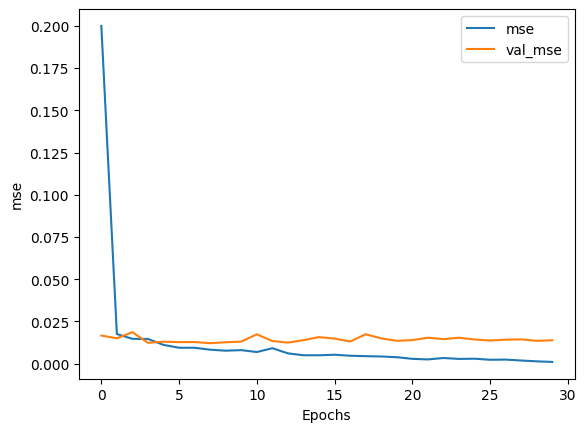

In [39]:
X_to_mean_train_tf = X_to_mean_train.values
X_to_mean_test_tf = X_to_mean_test.values
Y_normalized_train_tf = Y_normalized_train.values
Y_normalized_test_tf = Y_normalized_test.values
model_normalized = Sequential([Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(1, activation='linear')])
model_normalized.compile(loss=tf.keras.losses.mse, optimizer='adam', metrics = ['mse'])
history_normalized = model_normalized.fit(X_to_mean_train_tf,Y_normalized_train_tf,validation_data = (X_to_mean_test_tf,Y_normalized_test_tf), epochs=30,verbose=0)
Y_normalized_pred = model_normalized.predict(X_to_mean_test_tf, verbose=0)
Y_normalized_pred = pd.DataFrame(Y_normalized_pred)
plt.plot(history_normalized.history['mse'])
plt.plot(history_normalized.history['val_mse'])
plt.xlabel("Epochs")
plt.ylabel('mse')
plt.legend(['mse', 'val_mse'])
plt.show()

### Linear Regression Neural Network with normalized data

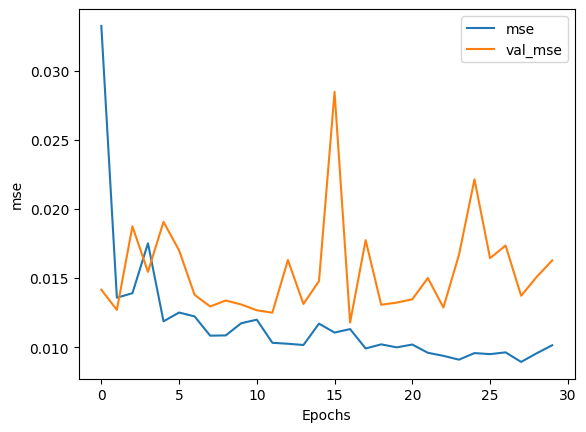

In [40]:
X_normalized_train_tf = X_normalized_train.values
X_normalized_test_tf = X_normalized_test.values
Y_normalized_train_tf = Y_normalized_train.values
Y_normalized_test_tf = Y_normalized_test.values
model_normalized = Sequential([Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(1, activation='linear')])
model_normalized.compile(loss=tf.keras.losses.mse, optimizer='adam', metrics = ['mse'])
history_normalized = model_normalized.fit(X_normalized_train_tf,Y_normalized_train_tf,validation_data = (X_normalized_test_tf,Y_normalized_test_tf), epochs=30,verbose=0)
Y_normalized_pred = model_normalized.predict(X_normalized_test_tf, verbose=0)
Y_normalized_pred = pd.DataFrame(Y_normalized_pred)
plt.plot(history_normalized.history['mse'])
plt.plot(history_normalized.history['val_mse'])
plt.xlabel("Epochs")
plt.ylabel('mse')
plt.legend(['mse', 'val_mse'])
plt.show()

## Hyperparameter Tuning

Having selected the models we think are most relevant, we proceed to tune them in order to achieve the best possible performance and generalization. This involves testing their performance with different combinations of parameters.

### KNN for multiclass classification with difference to mean trimmed data

C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` inste

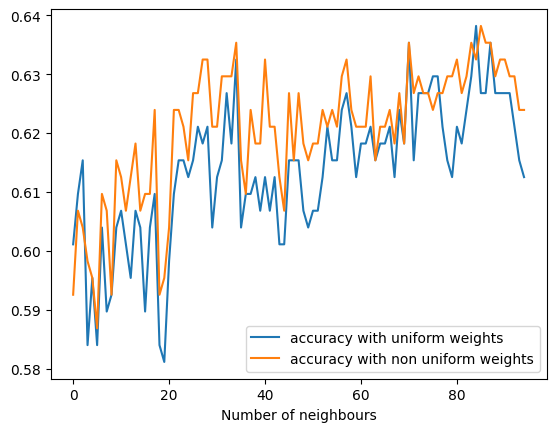

Best accuracy at 89 neighbours and uniform distance with 0.6381766381766382 accuracy 


In [41]:
X_to_mean_test_trimmed = X_to_mean_test_trimmed.fillna(0)
bestw = -1
besti = -1
bestacc  = -1
accw1 = []
accw2 = []
for w in ['uniform','distance']:
    for i in range(5,100):
        knn_trimmed = KNeighborsClassifier(n_neighbors=i,weights=w)
        knn_trimmed.fit(X_to_mean_train_trimmed, Y_train)
        Y_pred_trimmed = knn_trimmed.predict(X_to_mean_test_trimmed)
        accuracy_trimmed = accuracy_score(Y_test, Y_pred_trimmed)
        if w == 'uniform':
            accw1.append(accuracy_trimmed)
        else:
            accw2.append(accuracy_trimmed)
        if accuracy_trimmed > bestacc:
            bestacc = accuracy_trimmed
            besti = i
            bestw = w
            best_model = knn_trimmed
plt.plot(accw1)
plt.plot(accw2)
plt.xlabel('Number of neighbours')
plt.legend(['accuracy with uniform weights', 'accuracy with non uniform weights'])
plt.show()
if bestw == 'uniform':
    distance = 'uniform'
else:
    distance = 'non uniform'
print(f"Best accuracy at {besti} neighbours and {distance} distance with {bestacc} accuracy ")
pickle.dump(best_model, open('best_multiclass_knn', 'wb'))

although we can see a lot of spikes in performance, we also verify an overall approximately linear improvement in performance as the number of neighbors increases. The model performs significantly better than random guessing. However, this performance is not what we desire to achieve, particularly in the healthcare setting

### KNN for binary class classification with normalized trimmed data

C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` inste

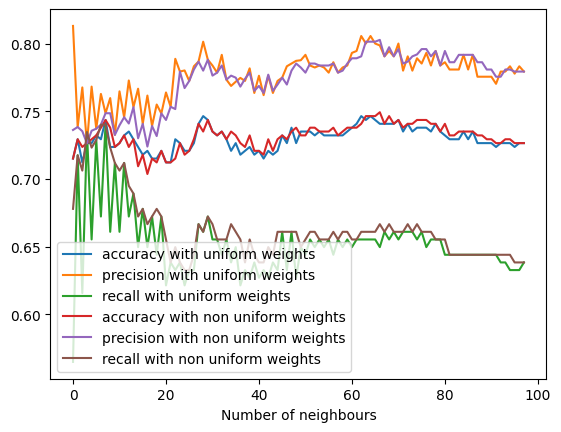

Best accuracy at 68 neighbours and non uniform distance with 0.7492877492877493 accuracy 


In [42]:
bestw = -1
besti = -1
bestacc  = -1
accw1 = []
prew1 = []
recw1 = []
accw2 = []
prew2 = []
recw2 = []
for w in ['uniform','distance']:
    for i in range(2,100):
        knn_binary_trimmed = KNeighborsClassifier(n_neighbors=i, weights=w)
        knn_binary_trimmed.fit(X_normalized_train_trimmed, Y_binary_train)
        Y_binary_pred_trimmed = knn_binary_trimmed.predict(X_normalized_test_trimmed)
        binary_accuracy_trimmed = accuracy_score(Y_binary_test, Y_binary_pred_trimmed)
        binary_precision_trimmed = precision_score(Y_binary_test, Y_binary_pred_trimmed)
        binary_recall_trimmed = recall_score(Y_binary_test, Y_binary_pred_trimmed)
        if w == 'uniform':
            accw1.append(binary_accuracy_trimmed)
            prew1.append(binary_precision_trimmed)
            recw1.append(binary_recall_trimmed)
        else:
            accw2.append(binary_accuracy_trimmed)
            prew2.append(binary_precision_trimmed)
            recw2.append(binary_recall_trimmed)
        if binary_accuracy_trimmed > bestacc:
            bestacc = binary_accuracy_trimmed
            besti = i
            bestw = w
            best_model = knn_binary_trimmed
plt.plot(accw1)
plt.plot(prew1)
plt.plot(recw1)
plt.plot(accw2)
plt.plot(prew2)
plt.plot(recw2)
plt.xlabel('Number of neighbours')
plt.legend(['accuracy with uniform weights', 'precision with uniform weights', 'recall with uniform weights','accuracy with non uniform weights', 'precision with non uniform weights', 'recall with non uniform weights'])
plt.show()
if bestw == 'uniform':
    distance = 'uniform'
else:
    distance = 'non uniform'
print(f"Best accuracy at {besti} neighbours and {distance} distance with {bestacc} accuracy ")
pickle.dump(best_model, open('best_binary_knn', 'wb'))


looking at the model's performance with binary labeling, we see that the value is greater than the one obtained with multiclass. However, it is not greater than random guessing in the same magnitude that the previous model was, so it is hard to state that this model's performance is better and even harder to say that it would be a better fit for solving our problem, as it's prediction is less expressive while not offering much better performance.

### Neural Network for Linear Regression with normalized data 


In [43]:
best_neurons = 204
best_layers = 15

Best number of neurons is 91 with a mse of 0.010450043715536594


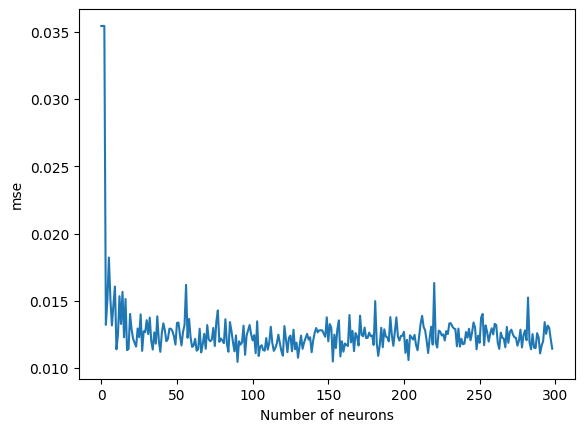

In [44]:
X_normalized_train_tf = X_normalized_train.values
X_normalized_test_tf = X_normalized_test.values
Y_normalized_train_tf = Y_normalized_train.values
Y_normalized_test_tf = Y_normalized_test.values

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8) #early stopping
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=1,min_lr=0.0001) #reducing learning rate


lowest_mse = 10000000
best_neurons = 0
mse_per_neurons = []

for neurons in range (1,300):
    model_normalized = Sequential([Dense(neurons, activation='relu'),Dense(neurons, activation='relu'),Dense(neurons, activation='relu'),Dense(neurons, activation='relu'),Dense(neurons, activation='relu'),Dense(1, activation='linear')])

    model_normalized.compile(loss=tf.keras.losses.mse, optimizer='adam', metrics = ['mse'])
    history_normalized = model_normalized.fit(X_normalized_train_tf,Y_normalized_train_tf,validation_data = (X_normalized_test_tf,Y_normalized_test_tf), epochs=100,verbose=0,callbacks = [callback, lr_callback])
    mse_per_neurons.append(history_normalized.history['val_mse'][-1])
    if history_normalized.history['val_mse'][-1] < lowest_mse:
        lowest_mse = history_normalized.history['val_mse'][-1]
        best_neurons = neurons
        best_model = model_normalized
plt.plot(mse_per_neurons)
plt.xlabel("Number of neurons")
plt.ylabel('mse')
print(f"Best number of neurons is {best_neurons} with a mse of {lowest_mse}")
best_model.save('best_neural_network.keras')

Best number of hidden layers is 36 with a mse of 0.011054984293878078


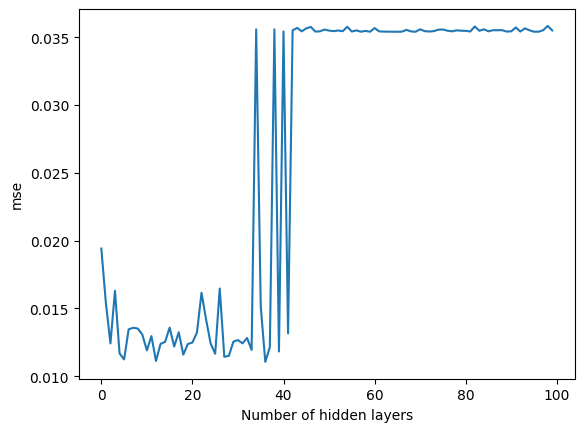

In [45]:
X_normalized_train_tf = X_normalized_train.values
X_normalized_test_tf = X_normalized_test.values
Y_normalized_train_tf = Y_normalized_train.values
Y_normalized_test_tf = Y_normalized_test.values

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8) #early stopping
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=1,min_lr=0.0001) #reducing learning rate

lowest_mse = 10000000
best_layers = -1
mse_per_layers= []

for nlayers in range (100):
    model_normalized = Sequential()
    for i in range(nlayers):
        model_normalized.add(tf.keras.layers.Dense(best_neurons,activation='relu'))
    model_normalized.add(tf.keras.layers.Dense(1,activation='linear'))
    model_normalized.compile(loss=tf.keras.losses.mse, optimizer='adam', metrics = ['mse'])
    history_normalized = model_normalized.fit(X_normalized_train_tf,Y_normalized_train_tf,validation_data = (X_normalized_test_tf,Y_normalized_test_tf), epochs=100,verbose=0, callbacks=[callback,lr_callback])
    mse_per_layers.append(history_normalized.history['val_mse'][-1])
    if history_normalized.history['val_mse'][-1] < lowest_mse:
        lowest_mse = history_normalized.history['val_mse'][-1]
        best_layers = nlayers
        best_model = model_normalized
plt.plot(mse_per_layers)
plt.xlabel("Number of hidden layers")
plt.ylabel('mse')
print(f"Best number of hidden layers is {best_layers} with a mse of {lowest_mse}")
best_model.save('best_neural_network.keras')

### Load the trained models

In [52]:
selected_feat= np.load('selected_features.npy', allow_pickle=True)
X_train_trimmed = X_train[selected_feat]
X_train_trimmed['InternalStructure'] = X_train['InternalStructure']
X_test_trimmed = X_test[selected_feat]
X_test_trimmed['InternalStructure'] = X_test['InternalStructure']
X_to_mean_train_trimmed = X_to_mean_train[selected_feat]
X_to_mean_train_trimmed['InternalStructure'] = X_to_mean_train['InternalStructure']
X_to_mean_test_trimmed = X_to_mean_test[selected_feat]
X_to_mean_test_trimmed['InternalStructure'] = X_to_mean_test['InternalStructure']
X_normalized_train_trimmed = X_normalized_train[selected_feat]
X_normalized_train_trimmed['InternalStructure'] = X_normalized_train['InternalStructure']
X_normalized_test_trimmed = X_normalized_test[selected_feat]
X_normalized_test_trimmed['InternalStructure'] = X_normalized_test['InternalStructure']
best_multiclass_knn = pickle.load(open('best_multiclass_knn', 'rb'))
best_binary_knn = pickle.load(open('best_binary_knn', 'rb'))
best_neural_network = tf.keras.models.load_model('best_neural_network.keras')

## Result Analysis

### Linear Regression Error

In [60]:
Y_normalized_pred = model_normalized.predict(X_normalized_test_tf, verbose=0)
Y_normalized_pred = pd.DataFrame(Y_normalized_pred)
print(f"Mean absolute error = {mean_absolute_error(Y_normalized_test,Y_normalized_pred)}")
print(f"Mean squared error = {mean_squared_error(Y_normalized_test,Y_normalized_pred)}")
print(f"Mean root squared error = {mean_squared_error(Y_normalized_test,Y_normalized_pred)**(1/2)}")
print(f"Mean squared log error = {mean_squared_log_error(Y_normalized_test,Y_normalized_pred)**(1/2)}")
print(f"Median absolute error = {median_absolute_error(Y_normalized_test,Y_normalized_pred)**(1/2)}")
print(f"R2 Score = {r2_score(Y_normalized_test,Y_normalized_pred)}")

Mean absolute error = 0.14837804263457402
Mean squared error = 0.03549450550192762
Mean root squared error = 0.18839985536599443
Mean squared log error = 0.14413251933660248
Median absolute error = 0.35954051145505855
R2 Score = -0.002769868872665171


### KNN Binary Labeling Confusion Matrix

              precision    recall  f1-score   support

           0       0.71      0.83      0.77       174
           1       0.80      0.67      0.73       177

    accuracy                           0.75       351
   macro avg       0.76      0.75      0.75       351
weighted avg       0.76      0.75      0.75       351



<AxesSubplot:>

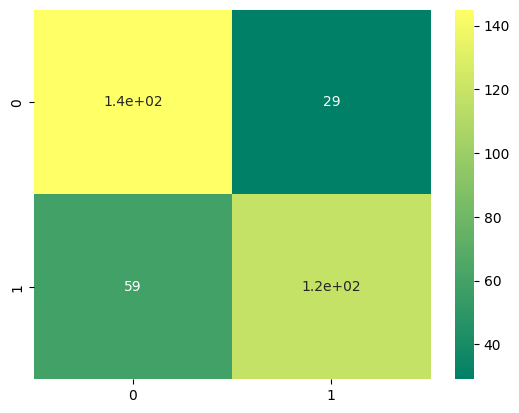

In [54]:
Y_pred_binary_knn = best_binary_knn.predict(X_normalized_test_trimmed)
print(classification_report(Y_binary_test,Y_pred_binary_knn))
sns.heatmap(metricssk.confusion_matrix(Y_binary_test,Y_pred_binary_knn), annot = True, cmap = 'summer')

### KNN Binary Labeling ROC Curve

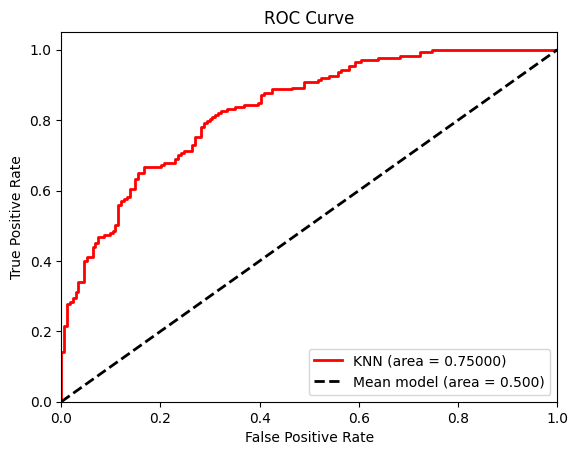

In [58]:
Y_binary_pred_prob = best_binary_knn.predict_proba(X_normalized_test_trimmed)
auc_score = roc_auc_score(Y_binary_test, Y_pred_binary_knn)  
fpr, tpr, thresholds = roc_curve(Y_binary_test, Y_binary_pred_prob[:,1])  
plt.plot(fpr, tpr, color="red", lw=2,   label=f"KNN (area = {auc_score:0.5f})")  
plt.plot([0, 1], [0, 1], color="black", lw=2, linestyle="--",   label="Mean model (area = 0.500)")  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.05])  
plt.xlabel("False Positive Rate")  
plt.ylabel("True Positive Rate")  
plt.title("ROC Curve")  
plt.legend(loc="lower right")  
plt.show()

### KNN Multiclass Confusion Matrix

              precision    recall  f1-score   support

           1       0.90      0.84      0.87        43
           2       0.61      0.38      0.46       104
           3       0.58      0.82      0.68       139
           4       0.71      0.61      0.66        57
           5       1.00      0.00      0.00         8

    accuracy                           0.64       351
   macro avg       0.76      0.53      0.53       351
weighted avg       0.66      0.64      0.62       351



<AxesSubplot:>

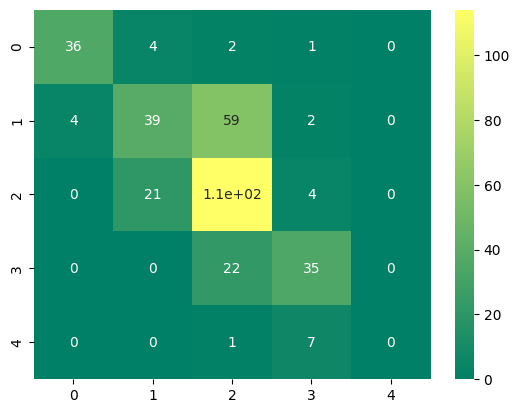

In [61]:
Y_pred_multiclass_knn = best_multiclass_knn.predict(X_to_mean_test_trimmed)
print(classification_report(Y_test,Y_pred_multiclass_knn, zero_division=True))
sns.heatmap(metricssk.confusion_matrix(Y_test,Y_pred_multiclass_knn), annot = True, cmap = 'summer')

### Neural Network Performance Analysis

### Feature Importance

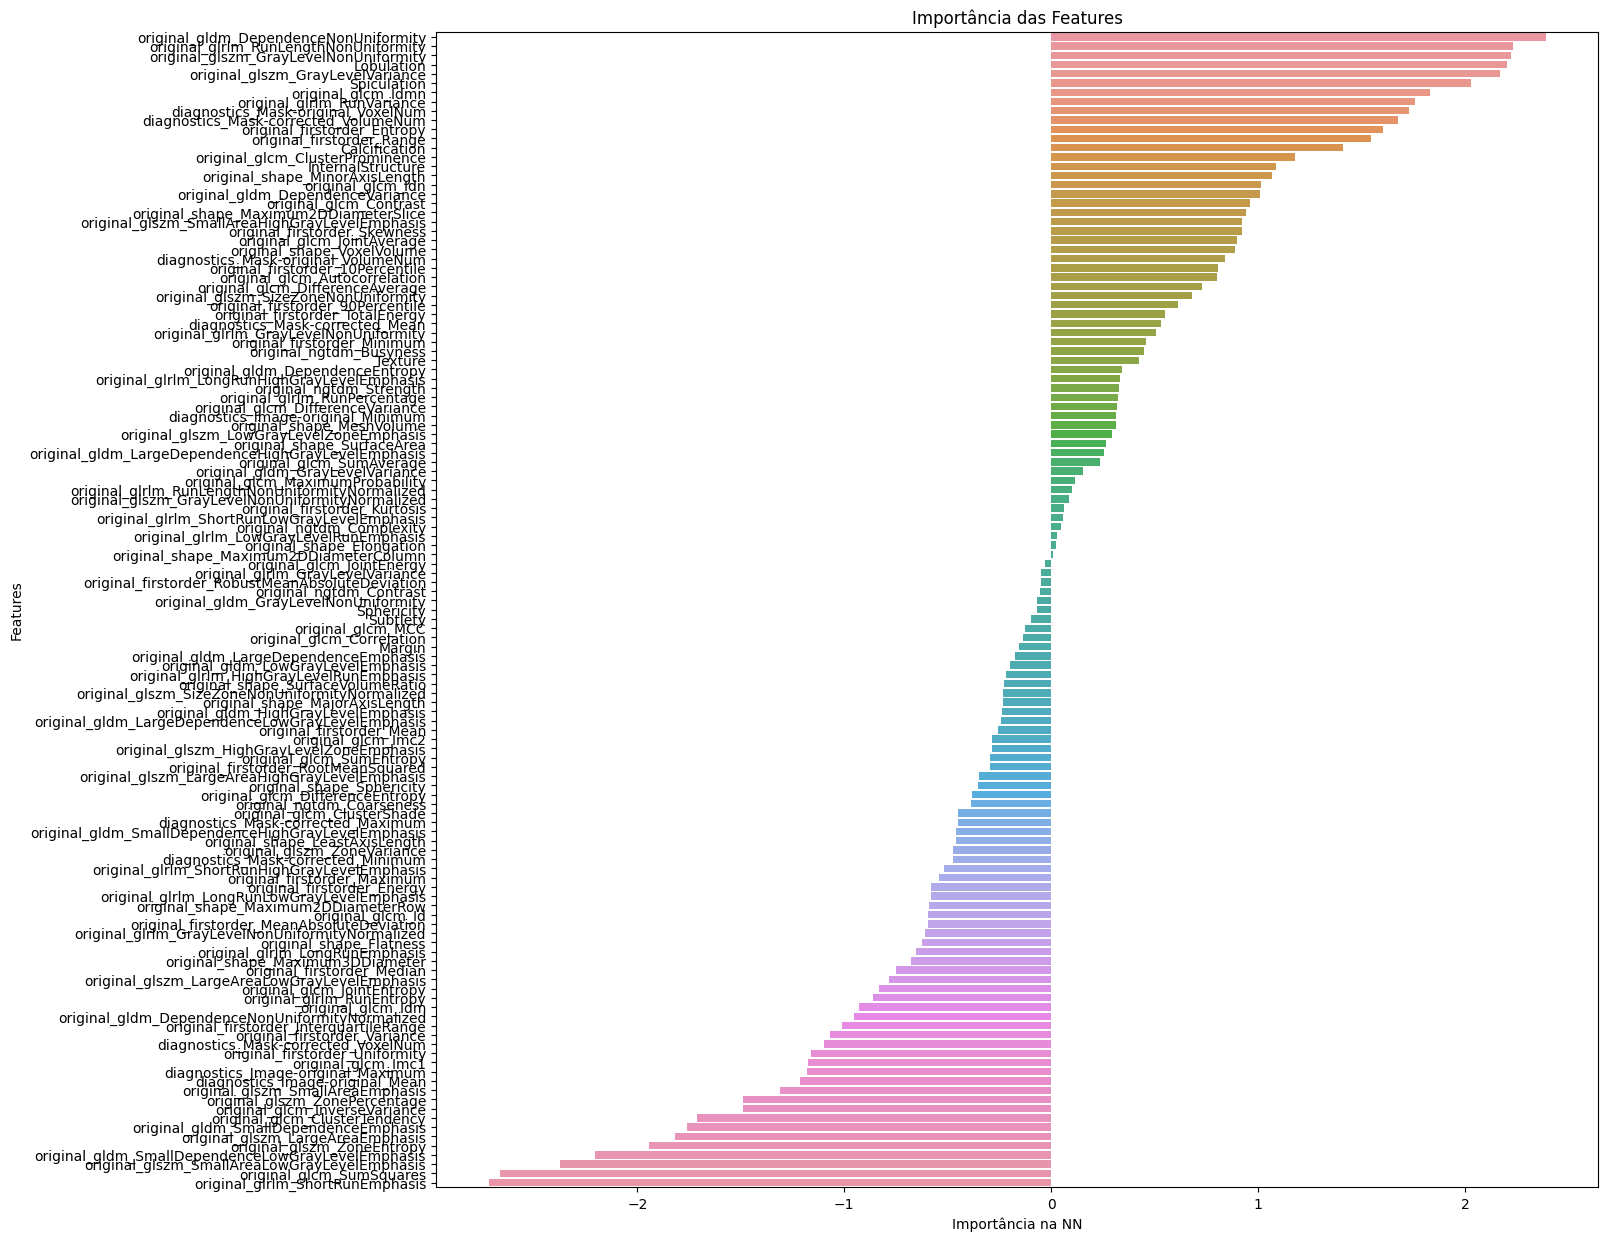

In [84]:
# graph importance of all features

importance = best_neural_network.layers[0].get_weights()[0]
importance = pd.DataFrame(importance)
importance = importance.sum(axis=1)
importance = importance.sort_values(ascending=False)
importance = importance.reset_index()
importance = importance.rename(columns={'index':'feature', 0:'importance'})
importance['feature'] = importance['feature'].astype(int)

importance['feature'] = importance['feature'].apply(lambda x: X_normalized_train.columns[x])

plt.figure(figsize=(15,15))
sns.barplot(x='importance', y='feature', data=importance)
plt.title('Importância das Features')
plt.xlabel('Importância na NN') 
plt.ylabel('Features')
plt.show()

We can see that the least impactful features are the ones which the sum of their absolute values is smaller, as shown here:

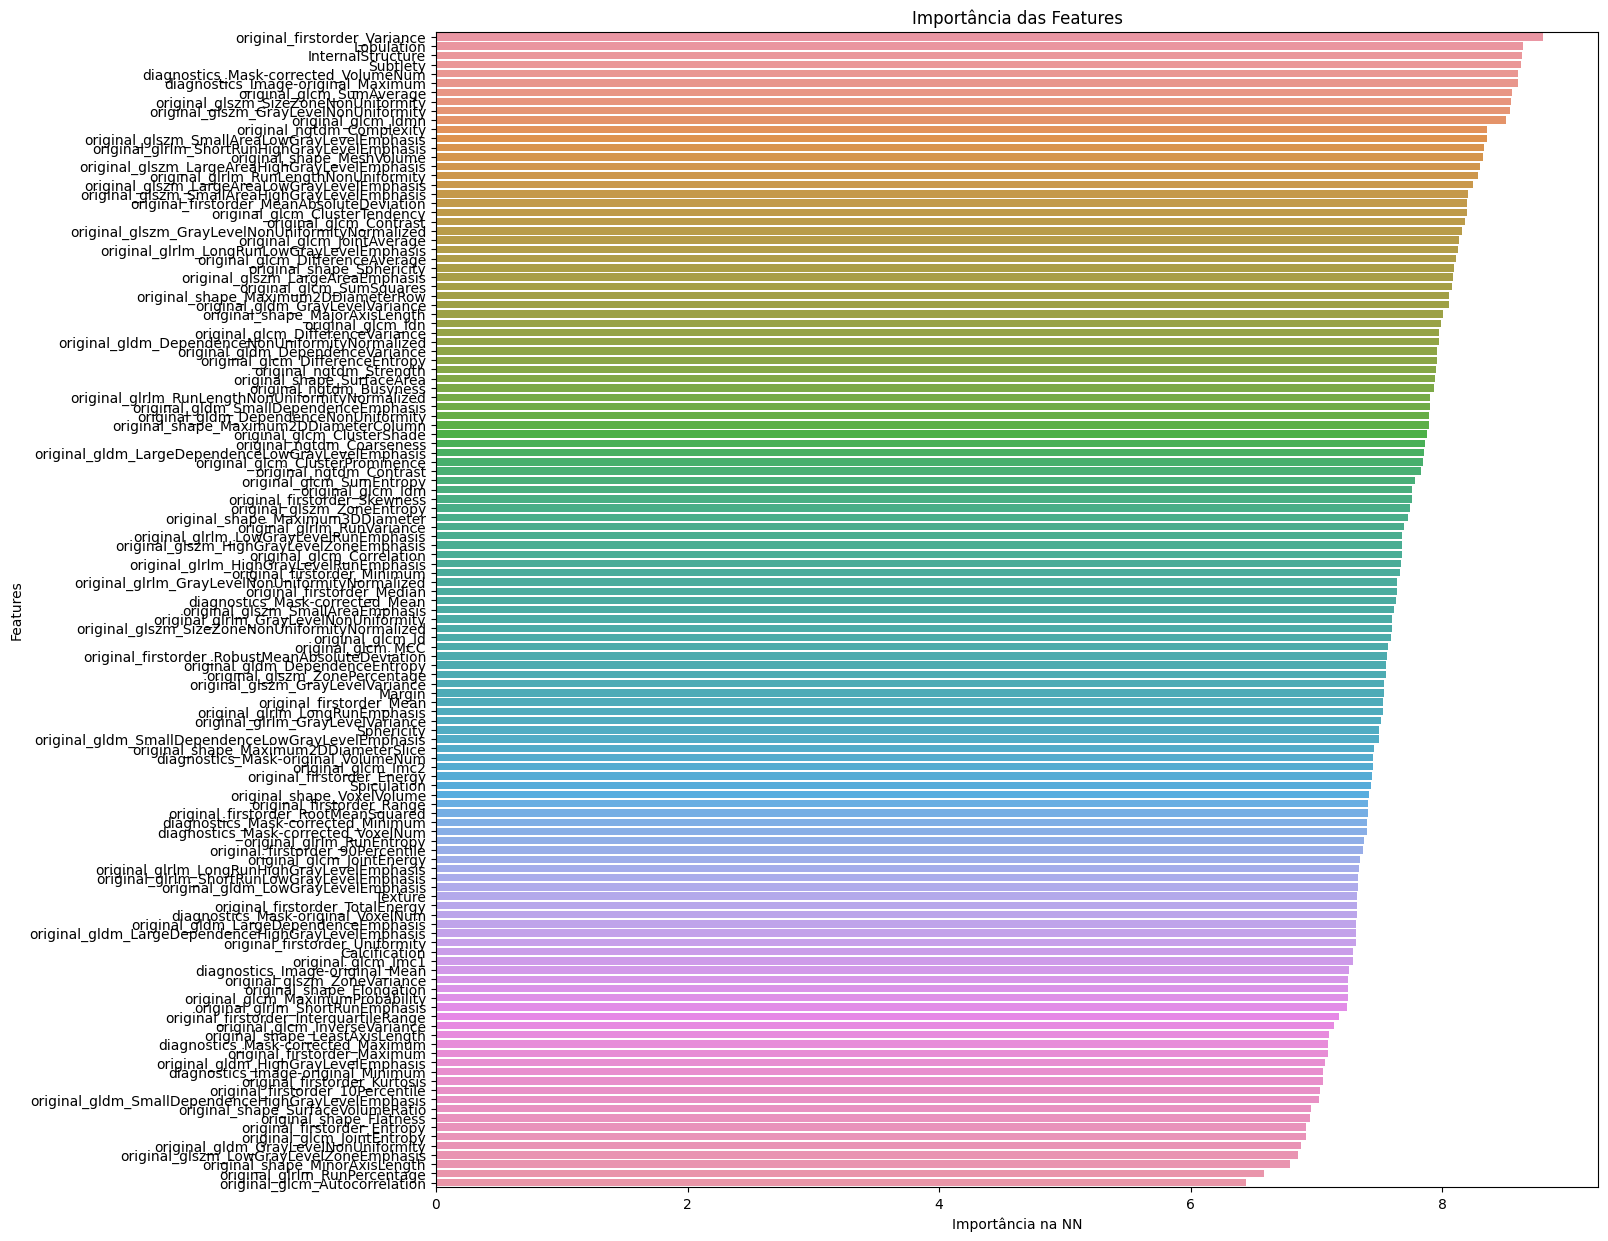

In [86]:
importance = best_neural_network.layers[0].get_weights()[0]
importance = pd.DataFrame(importance)
importance = importance.abs()
importance = importance.sum(axis=1)
importance = importance.sort_values(ascending=False)
importance = importance.reset_index()
importance = importance.rename(columns={'index':'feature', 0:'importance'})
importance['feature'] = importance['feature'].astype(int)

importance['feature'] = importance['feature'].apply(lambda x: X_normalized_train.columns[x])
plt.figure(figsize=(15,15))
sns.barplot(x='importance', y='feature', data=importance)
plt.title('Importância das Features')
plt.xlabel('Importância na NN') 
plt.ylabel('Features')
plt.show()

### Plotting prediction by true label

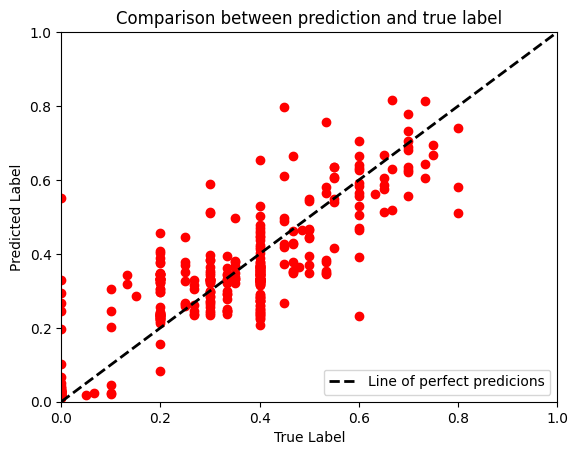

In [89]:
Y_normalized_pred = best_neural_network.predict(X_normalized_test_tf, verbose=0)
Y_normalized_pred = pd.DataFrame(Y_normalized_pred)
plt.plot(Y_normalized_test,Y_normalized_pred, 'ro')
plt.plot([0, 1], [0, 1], color="black", lw=2, linestyle="--",   label="Line of perfect predicions")  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.0])  
plt.xlabel("True Label")  
plt.ylabel("Predicted Label")  
plt.title("Comparison between prediction and true label")  
plt.legend(loc="lower right")  
plt.show()  